<a href="https://colab.research.google.com/github/pkol/ds0808/blob/master/OtoMoto_2_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OTOMOTO.pl - price prediction 
## PART2: Data analysis and preparation
Author: <b>Małgorzata Stolarska</b><br>
E-mail address: malgorzata.stolarska@gmail.com

The work is divided into three parts:
- OtoMoto 1 - WebScrapping.ipynb
- OtoMoto 2 - Data Preparation.ipynb
- OtoMoto 3 - Price Prediction.ipynb

<b>Purpose:</b> <br>
Building a model to predict car prices and classify prices as overstated, understated or average. <br>
Model learning will be performed on the data from the website https://www.otomoto.pl/, obtained by web scrapping. The source code, that was used to retrieve the data, is in the notebook: <b>OtoMoto 1 - WebScrapping.ipynb</b>.

<b>Assumptions:</b> <br>
The model will be predict prices in PLN for new and used cars, but not for damaged cars.

<b>Data description:</b><br>
The Polish names of columns correspond to the fields on the otomoto.pl website. The scope of the fields varies from offer to offer and may change over time. The fields required for the model are listed at the end of the document and any additional fields will be ignored.

In addition to the columns mentioned above, the dataset includes columns:
- **href:** link to the offer on the website (notice: it becomes inactive after the offer expires),
- **price_evaluation:** indicates whether the car's price is in the mid-range, above or below (the value corresponds to the icon on the website); not used in price prediction but it is the basis for classification,
- **price:** price of car,
- **currency:** only PLN supported (offers in other currencies should be removed from the data)
- **price_details:** additional information regarding the price, e.g. whether the price is negotiable,
- **seller_type:** offer from a private person or from a dealer,
- **seller_name:** field not used in price prediction.

The data used to analyze and build the model was valid on February 9, 2021.

## Imports, setting parameters and options

In [1]:
"""
# Required on Google Colab, if the path is on Google Drive:
"""
# Set Google Drive path 
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive/ForColab/OtoMoto"


# Local path:
# path = "data"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Required on Google Colab:
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install seaborn

Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.2)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [3]:
import pandas as pd
import numpy as np
import pickle
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import time, date, datetime, timezone, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, linear_model
from sklearn import  metrics
from sklearn.decomposition import PCA

# Pandas options
pd.set_option('display.float_format', '{:.4f}'.format) 
pd.set_option('display.max_columns', None) 
pd.set_option("max_colwidth", None)

# Sklearn options 
from sklearn import set_config
set_config(display='diagram') # interactive diagrams for pipelines

In [4]:
pd.__version__ # should be 1.2.2 or higher

'1.2.2'

## Data loading and preparation
Load data:

In [5]:
offers = pd.read_csv("/".join([path, "offers.csv"]), encoding="UTF-8", sep=",", dtype="str")

Delete columns:
- Column "Unnamed: 0" indexes rows.
- Column "Unnamed: 128" applies to 5 records, which have a "check" without description in the section "Wyposażenie", e.g.: https://www.otomoto.pl/oferta/bmw-x5-m-bmw-x5-m-ID6DBiiC.html
- "Możliwość finansowania", "Leasing", "Opłata początkowa", "Miesięczna rata", "Liczba pozostałych rat", "Wartość wykupu" - relate to leasing and a credit offer available on the website,
- "Numer rejestracyjny pojazdu", "VIN" - worthless for prediction and categorization,
- "Kategoria" - only for 1 category was downloaded (passenger cars).

In [6]:
offers.drop(columns=["Unnamed: 0", "Unnamed: 128", "Numer rejestracyjny pojazdu", "VIN", "Możliwość finansowania", \
                     "Leasing", "Opłata początkowa", "Miesięczna rata", "Liczba pozostałych rat", "Wartość wykupu", \
                     "Kategoria"], inplace=True)
offers.shape

(191866, 118)

In [7]:
offers.head(5)

,href,price_evaluation,price,currency,price_details,seller_type,seller_name,Oferta od,Marka pojazdu,Model pojazdu,Rok produkcji,Przebieg,Pojemność skokowa,Rodzaj paliwa,Moc,Skrzynia biegów,Napęd,Typ,Liczba drzwi,Liczba miejsc,Kolor,Faktura VAT,Kraj pochodzenia,Pierwsza rejestracja,Zarejestrowany w Polsce,Pierwszy właściciel,Bezwypadkowy,Serwisowany w ASO,Stan,Metalik,ABS,Bluetooth,Czujnik zmierzchu,Elektrycznie ustawiane lusterka,Gniazdo USB,Klimatyzacja automatyczna,MP3,Poduszka powietrzna chroniąca kolana,Poduszki boczne przednie,Radio niefabryczne,Światła do jazdy dziennej,Szyberdach,Alufelgi,Centralny zamek,Czujniki parkowania tylne,ESP (stabilizacja toru jazdy),Immobilizer,Komputer pokładowy,Ogranicznik prędkości,Poduszka powietrzna kierowcy,Poduszki boczne tylne,Radio fabryczne,Światła LED,Wielofunkcyjna kierownica,ASR (kontrola trakcji),Czujnik deszczu,Elektryczne szyby przednie,Gniazdo AUX,Isofix,Kurtyny powietrzne,Podgrzewane lusterka boczne,Poduszka powietrzna pasażera,Przyciemniane szyby,Światła Xenonowe,Światła przeciwmgielne,Wspomaganie kierownicy,Emisja CO2,Okres gwarancji producenta,Perłowy,Tuning,Alarm,CD,Tapicerka welurowa,Gniazdo SD,Tempomat,Dach panoramiczny,Podgrzewana przednia szyba,Klimatyzacja manualna,System Start-Stop,Matowy,Akryl (niemetalizowany),VAT marża,Asystent parkowania,Klimatyzacja dwustrefowa,Regulowane zawieszenie,Nawigacja GPS,Tapicerka skórzana,Elektrochromatyczne lusterko wsteczne,Uszkodzony,Czujniki parkowania przednie,Kamera cofania,Odtwarzacz DVD,Podgrzewane przednie siedzenia,Elektrochromatyczne lusterka boczne,Tuner TV,Wersja,Łopatki zmiany biegów,Elektryczne szyby tylne,lub do (przebieg km),Elektrycznie ustawiane fotele,Klimatyzacja czterostrefowa,Asystent pasa ruchu,Czujnik martwego pola,Zmieniarka CD,Relingi dachowe,Hak,Tempomat aktywny,Podgrzewane tylne siedzenia,Kierownica po prawej (Anglik),Gwarancja dealerska (w cenie),Ogrzewanie postojowe,Filtr cząstek stałych,Generacja,HUD (wyświetlacz przezierny),Homologacja ciężarowa,Zarejestrowany jako zabytek,Warranty if agreed with the buyer,Kod Silnika
0,https://www.otomoto.pl/oferta/abarth-595-pista-salon-pl-pierwszy-wlasciciel-fv-23-ID6DAiBz.html,above,79 999,PLN,Faktura VAT,Osoba prywatna,Paweł,Osoby prywatnej,Abarth,595,2018,12 150 km,1 400 cm3,Benzyna,160 KM,Manualna,Na przednie koła,Auta małe,2,4,Szary,Tak,Polska,24/05/2019,Tak,Tak,Tak,Tak,Używane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.otomoto.pl/oferta/abarth-695-1-4-16v-t-jet-180km-anniversario-tel-6-9-4-4-0-1-1-2-7-demo-ID6CVRFU.html,none,110 000,PLN,"Do negocjacji, Faktura VAT",Autoryzowany Dealer,"Grupa Gezet Fiat, Abarth, Alfa Romeo, Jeep, Honda, Opel, Suzuki, IVECO",Firmy,Abarth,695,2020,5 km,1 368 cm3,Benzyna,180 KM,Manualna,Na przednie koła,Kompakt,3,4,Zielony,Tak,Polska,NaN,NaN,NaN,Tak,NaN,Nowe,Tak,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.otomoto.pl/oferta/abarth-595-abarth-595-elaborabile-1-4-t-jet-salon-pl-fv-23-vat-ID6DzCSm.html,in,63 500,PLN,Faktura VAT,Osoba prywatna,Piotr,Osoby prywatnej,Abarth,595,2017,39 000 km,1 400 cm3,Benzyna,145 KM,Manualna,Na przednie koła,Auta małe,3,4,Biały,Tak,Polska,19/07/2017,Tak,NaN,Tak,Tak,Używane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154 g/km,17/07/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [8]:
# Duplicated rows - don't exist
offers.duplicated().sum()

0

In [9]:
# Rows without price - don't exist
offers.price.isna().any()

False

### Remove foreign currencies (only PLN will be handled)
Delete rows with currencies other then PLN. The model will be build for PLN and will return forecasts in PLN.

In [10]:
# Rows with foreign currencies
offers.currency.value_counts()

PLN    191665
EUR       201
Name: currency, dtype: int64

In [11]:
# Delete rows with foreign currencies
offers = offers[offers.currency == "PLN"].copy()
offers.shape

(191665, 118)

### Remove damaged cars
The price of damaged cars depends mainly on the type of damage. As the downloaded data did not provide such information, the model should not be used to estimate prices of broken cars.

In [12]:
offers.Uszkodzony.fillna("Nie", inplace=True)
print(offers.Uszkodzony.value_counts(dropna=False))
print("Number of broken cars: {:}, {:.2} % of the total data.".format(\
       offers[offers.Uszkodzony == "Tak"].shape[0], \
       offers[offers.Uszkodzony == "Tak"].shape[0] * 100 / offers.shape[0]))

Nie    184238
Tak      7427
Name: Uszkodzony, dtype: int64
Number of broken cars: 7427, 3.9 % of the total data.


In [13]:
# Delete offers for broken cars
offers = offers[offers.Uszkodzony == "Nie"].copy()
offers.shape

(184238, 118)

### Remove offers from tests
Remove offers that explicitly come from testing.<br>
Notice: some listings with the word "test" are real and relate to test vehicle offers.

In [14]:
# Based on "seller_name":
offers_to_remove = offers[offers["seller_name"].apply(lambda x: True if pd.notna(x) and \
                                           re.search("test", x) is not None and \
                                           re.search("Motortest", x) is None \
                                           else False)]
# Add based on description in "href":
offers_to_remove = offers_to_remove.append(offers[offers["href"].apply(lambda x: True if 
                                           re.search("testowe", x) is not None and \
                                           re.search("auto-testowe", x) is None and \
                                           re.search("testowego", x) is None 
                                           else False)]).drop_duplicates()
                                          
offers_to_remove[["href", "seller_name", "price", "Przebieg", "Marka pojazdu", "Rok produkcji"]]

,href,seller_name,price,Przebieg,Marka pojazdu,Rok produkcji
180540,https://www.otomoto.pl/oferta/volkswagen-golf-ogloszenie-testowe-ID6Dmox4.html,konto_testowe1,400 000,1 000 000 km,Volkswagen,2018
191856,https://www.otomoto.pl/oferta/zaporozec-ID6D3kgM.html,test,33 333,500 000 000 km,Zaporożec,2020
119257,https://www.otomoto.pl/oferta/opel-antara-testowe-ID6Dyxue.html,Agnieszka,123 456 789,12 311 km,Opel,2020


We can see on the OtoMoto.pl website that these are test items. We remove them because they introduce unreliable values to the data.

In [15]:
offers.drop(index=offers_to_remove.index, inplace=True)
offers.shape

(184235, 118)

### Convert strings with numeric values to float

In [16]:
# Remove spaces and units from numeric values
units = {"price": "", \
         "Przebieg": "km", \
         "Pojemność skokowa": "cm3", \
         "Moc": "KM", \
         "Emisja CO2": "g/km", \
         "Rok produkcji": "", \
         "Liczba drzwi": "", \
         "Liczba miejsc": ""}

cols = [] 
for key, val in units.items():
    offers[key] = offers[key].apply(lambda x: x if type(x) == float else \
                                    re.sub(",", ".", re.sub(val, "", "".join(x.split())))).astype(float)
    cols.append(key)
      
offers[cols].head()

,price,Przebieg,Pojemność skokowa,Moc,Emisja CO2,Rok produkcji,Liczba drzwi,Liczba miejsc
0,79999.0000,12150.0000,1400.0000,160.0000,NaN,2018.0000,2.0000,4.0000
1,110000.0000,5.0000,1368.0000,180.0000,NaN,2020.0000,3.0000,4.0000
2,63500.0000,39000.0000,1400.0000,145.0000,154.0000,2017.0000,3.0000,4.0000
3,36900.0000,209606.0000,1400.0000,190.0000,155.0000,2009.0000,3.0000,4.0000
4,84300.0000,1.0000,1368.0000,145.0000,NaN,2020.0000,3.0000,NaN


In [17]:
# Check types
offers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184235 entries, 0 to 191865
Data columns (total 118 columns):
 #    Column                                 Dtype  
---   ------                                 -----  
 0    href                                   object 
 1    price_evaluation                       object 
 2    price                                  float64
 3    currency                               object 
 4    price_details                          object 
 5    seller_type                            object 
 6    seller_name                            object 
 7    Oferta od                              object 
 8    Marka pojazdu                          object 
 9    Model pojazdu                          object 
 10   Rok produkcji                          float64
 11   Przebieg                               float64
 12   Pojemność skokowa                      float64
 13   Rodzaj paliwa                          object 
 14   Moc                               

### [Save checkpoint]

In [18]:
# Dump offers to pickle
with open("/".join([path, "prepared_offers.obj"]), "wb") as fp:
    pickle.dump(offers, fp)

In [19]:
# Read offers from pickle 
with open("/".join([path, "prepared_offers.obj"]), 'rb') as fp:
    offers = pickle.load(fp)

## Split data set into training and test parts

In [20]:
X = offers.drop(columns="price")
y = offers.price

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state = 33)

In [22]:
# Training data set
X_train.shape, y_train.shape

((175023, 117), (175023,))

In [23]:
# Test data set
X_test.shape, y_test.shape

((9212, 117), (9212,))

In [24]:
offers = None # remove from memory

In [25]:
# X_train.info(verbose=True)

## Data review on the training set
Review of the data (without looking at the test set).

In [26]:
X_train.head(10)

,href,price_evaluation,currency,price_details,seller_type,seller_name,Oferta od,Marka pojazdu,Model pojazdu,Rok produkcji,Przebieg,Pojemność skokowa,Rodzaj paliwa,Moc,Skrzynia biegów,Napęd,Typ,Liczba drzwi,Liczba miejsc,Kolor,Faktura VAT,Kraj pochodzenia,Pierwsza rejestracja,Zarejestrowany w Polsce,Pierwszy właściciel,Bezwypadkowy,Serwisowany w ASO,Stan,Metalik,ABS,Bluetooth,Czujnik zmierzchu,Elektrycznie ustawiane lusterka,Gniazdo USB,Klimatyzacja automatyczna,MP3,Poduszka powietrzna chroniąca kolana,Poduszki boczne przednie,Radio niefabryczne,Światła do jazdy dziennej,Szyberdach,Alufelgi,Centralny zamek,Czujniki parkowania tylne,ESP (stabilizacja toru jazdy),Immobilizer,Komputer pokładowy,Ogranicznik prędkości,Poduszka powietrzna kierowcy,Poduszki boczne tylne,Radio fabryczne,Światła LED,Wielofunkcyjna kierownica,ASR (kontrola trakcji),Czujnik deszczu,Elektryczne szyby przednie,Gniazdo AUX,Isofix,Kurtyny powietrzne,Podgrzewane lusterka boczne,Poduszka powietrzna pasażera,Przyciemniane szyby,Światła Xenonowe,Światła przeciwmgielne,Wspomaganie kierownicy,Emisja CO2,Okres gwarancji producenta,Perłowy,Tuning,Alarm,CD,Tapicerka welurowa,Gniazdo SD,Tempomat,Dach panoramiczny,Podgrzewana przednia szyba,Klimatyzacja manualna,System Start-Stop,Matowy,Akryl (niemetalizowany),VAT marża,Asystent parkowania,Klimatyzacja dwustrefowa,Regulowane zawieszenie,Nawigacja GPS,Tapicerka skórzana,Elektrochromatyczne lusterko wsteczne,Uszkodzony,Czujniki parkowania przednie,Kamera cofania,Odtwarzacz DVD,Podgrzewane przednie siedzenia,Elektrochromatyczne lusterka boczne,Tuner TV,Wersja,Łopatki zmiany biegów,Elektryczne szyby tylne,lub do (przebieg km),Elektrycznie ustawiane fotele,Klimatyzacja czterostrefowa,Asystent pasa ruchu,Czujnik martwego pola,Zmieniarka CD,Relingi dachowe,Hak,Tempomat aktywny,Podgrzewane tylne siedzenia,Kierownica po prawej (Anglik),Gwarancja dealerska (w cenie),Ogrzewanie postojowe,Filtr cząstek stałych,Generacja,HUD (wyświetlacz przezierny),Homologacja ciężarowa,Zarejestrowany jako zabytek,Warranty if agreed with the buyer,Kod Silnika
14515,https://www.otomoto.pl/oferta/audi-a6-audi-a6-c6-lift-2-0-tdi-tiptronic-170km-model-2010-ID6CKbrp.html,in,PLN,Do negocjacji,Osoba prywatna,Magdalena,Osoby prywatnej,Audi,A6,2009.0000,240000.0000,1968.0000,Diesel,170.0000,Automatyczna,Na przednie koła,Sedan,4.0000,5.0000,Inny kolor,NaN,Niemcy,NaN,Tak,NaN,NaN,NaN,Używane,Tak,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,153.0000,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,Nie,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Tak,C6 (2004-2011),NaN,NaN,NaN,NaN,NaN
175904,https://www.otomoto.pl/oferta/volkswagen-passat-salon-pl-f-vat-23-serwis-aso-gwarancja-ID6DyECT.html,above,PLN,"Do negocjacji, Faktura VAT",Dealer,JEEPEK CAR,Firmy,Volkswagen,Passat,2016.0000,150000.0000,1400.0000,Benzyna,150.0000,Manualna,Na przednie koła,Sedan,4.0000,5.0000,Niebieski,Tak,Polska,NaN,Tak,Tak,Tak,Tak,Używane,Tak,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,Tak,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,Nie,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 miesięcy,NaN,NaN,B8 (2014-),NaN,NaN,NaN,NaN,NaN
155128,https://www.otomoto.pl/oferta/skoda-fabia-export-netto-1-wl-pelen-serwis-viber-ID6DyiSH.html,below,PLN,"Możliwość odliczenia VAT, Do negocjacji, Faktura VAT",Dealer,AUTOHANDEL OLEG,Firmy,Škoda,Fabia,2017.0000,180000.0000,999.0000,Benzyna,75.0000,Manualna,Na przednie koła,Kombi,5.0000,5.0000,Biały,Tak,NaN,NaN,NaN,Tak,Tak,Tak,Używane,Tak,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,111.0000,NaN,NaN,NaN,1.0,1.0,NaN,1.

In [27]:
# Columns with NaN
with pd.option_context("display.max_rows", X_train.shape[1]):
    print(X_train.isna().any()[X_train.isna().any()])

price_details                            True
seller_name                              True
Przebieg                                 True
Pojemność skokowa                        True
Moc                                      True
Skrzynia biegów                          True
Napęd                                    True
Liczba drzwi                             True
Liczba miejsc                            True
Faktura VAT                              True
Kraj pochodzenia                         True
Pierwsza rejestracja                     True
Zarejestrowany w Polsce                  True
Pierwszy właściciel                      True
Bezwypadkowy                             True
Serwisowany w ASO                        True
Metalik                                  True
ABS                                      True
Bluetooth                                True
Czujnik zmierzchu                        True
Elektrycznie ustawiane lusterka          True
Gniazdo USB                       

In [28]:
# Number of non-empty values in column
with pd.option_context("display.max_rows", X_train.shape[1]):
    print(X_train.count())

href                                     175023
price_evaluation                         175023
currency                                 175023
price_details                            126989
seller_type                              175023
seller_name                              168656
Oferta od                                175023
Marka pojazdu                            175023
Model pojazdu                            175023
Rok produkcji                            175023
Przebieg                                 173947
Pojemność skokowa                        173160
Rodzaj paliwa                            175023
Moc                                      173857
Skrzynia biegów                          174063
Napęd                                    162120
Typ                                      175023
Liczba drzwi                             172418
Liczba miejsc                            163812
Kolor                                    175023
Faktura VAT                             

In [29]:
# Counted values in columns
for col in X_train.columns[1:]:
    print("Column:", col)
    with pd.option_context("display.max_rows", 20):
        print(X_train[col].value_counts(dropna=False))
    print("-" * 30)

Column: price_evaluation
in       66160
none     54326
below    29344
above    25193
Name: price_evaluation, dtype: int64
------------------------------
Column: currency
PLN    175023
Name: currency, dtype: int64
------------------------------
Column: price_details
Do negocjacji                                           70159
NaN                                                     48034
Faktura VAT                                             34067
Do negocjacji, Faktura VAT                              14917
Możliwość odliczenia VAT, Faktura VAT                    3729
Możliwość odliczenia VAT, Do negocjacji, Faktura VAT     3607
Możliwość odliczenia VAT                                  324
Możliwość odliczenia VAT, Do negocjacji                   186
Name: price_details, dtype: int64
------------------------------
Column: seller_type
Dealer                 73735
Osoba prywatna         69311
Autoryzowany Dealer    31977
Name: seller_type, dtype: int64
------------------------------
Col

In [30]:
# Car brands
car_brands = dict(X_train["Marka pojazdu"].value_counts())
car_brands

{'Abarth': 33,
 'Acura': 13,
 'Aixam': 88,
 'Alfa Romeo': 1188,
 'Alpine': 5,
 'Aston Martin': 17,
 'Audi': 13083,
 'Austin': 3,
 'Autobianchi': 2,
 'BAC': 1,
 'BMW': 14035,
 'Bentley': 57,
 'Brilliance': 2,
 'Buick': 18,
 'Cadillac': 93,
 'Casalini': 3,
 'Chatenet': 5,
 'Chevrolet': 1275,
 'Chrysler': 559,
 'Citroën': 6114,
 'Cupra': 157,
 'DFSK': 4,
 'DKW': 3,
 'DS Automobiles': 110,
 'Dacia': 1516,
 'Daewoo': 81,
 'Daihatsu': 112,
 'De Lorean': 2,
 'Dodge': 483,
 'Ferrari': 44,
 'Fiat': 4042,
 'Ford': 13565,
 'GMC': 15,
 'Gaz': 3,
 'Grecav': 1,
 'Holden': 1,
 'Honda': 3628,
 'Hummer': 21,
 'Hyundai': 5187,
 'Infiniti': 199,
 'Inny': 55,
 'Isuzu': 52,
 'Iveco': 3,
 'Jaguar': 770,
 'Jeep': 1354,
 'Kia': 5072,
 'Lada': 20,
 'Lamborghini': 21,
 'Lancia': 191,
 'Land Rover': 969,
 'Lexus': 923,
 'Ligier': 20,
 'Lincoln': 47,
 'Lotus': 2,
 'MG': 13,
 'Maserati': 130,
 'Maybach': 4,
 'Mazda': 3836,
 'McLaren': 24,
 'Mercedes-Benz': 9881,
 'Mercury': 1,
 'Microcar': 43,
 'Mini': 1266,
 'Mit

In [31]:
X_train.describe()

,Rok produkcji,Przebieg,Pojemność skokowa,Moc,Liczba drzwi,Liczba miejsc,Emisja CO2
count,175023.0000,173947.0000,173160.0000,173857.0000,172418.0000,163812.0000,71519.0000
mean,2012.4180,715181.4425,1860.7588,151.1641,4.6820,5.0430,152.9504
std,6.5132,239782897.7427,701.8160,76.4210,0.7283,0.6980,920.6483
min,1908.0000,1.0000,400.0000,1.0000,1.0000,1.0000,1.0000
25%,2008.0000,44107.5000,1461.0000,105.0000,5.0000,5.0000,120.0000
50%,2013.0000,138800.0000,1796.0000,136.0000,5.0000,5.0000,140.0000
75%,2018.0000,199000.0000,1997.0000,170.0000,5.0000,5.0000,163.0000
max,2021.0000,99999999999.0000,8400.0000,1499.0000,55.0000,9.0000,123153.0000


In [32]:
# price
y_train.describe()

count        175023.0000
mean         122299.4036
std        23903007.2567
min             500.0000
25%           18900.0000
50%           37500.0000
75%           78900.0000
max     10000000000.0000
Name: price, dtype: float64

## Outliers
The preparation of the training data for model learning by removing or correcting outliers.<br>
Notice: this part will not be executed on the test data set and during the prediction.
#### Prices
Check offers with outlier prices:

In [33]:
# Price
ind = y_train[y_train > 3000000].index
X_train.join(y_train).loc[ind, ["price", "href", "Marka pojazdu", "Rok produkcji"]]

,price,href,Marka pojazdu,Rok produkcji
81347,10000000000.0000,https://www.otomoto.pl/oferta/land-rover-range-rover-evoque-najdrozsza-wersja-panorama-skora-ledy-okazja-ID6DBvdT.html,Land Rover,2016.0000
98030,3490000.0000,https://www.otomoto.pl/oferta/mercedes-benz-slr-slr-mclaren-roadster-722-s-salon-pl-1-wlasciciel-ID6Bq78E.html,Mercedes-Benz,2009.0000


In [34]:
# Remove
X_train = X_train.drop(index=ind).copy()
y_train = y_train.drop(index=ind).copy()

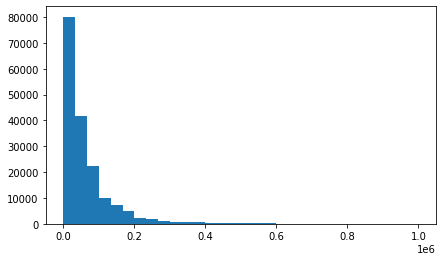

In [35]:
# Histogram for prices
plt.figure(figsize=(7,4))
plt.hist(y_train, bins=30, range=(0, 1000000))
plt.show()

In [36]:
y_train.describe()

count    175021.0000
mean      65144.8599
std       87499.0646
min         500.0000
25%       18900.0000
50%       37500.0000
75%       78900.0000
max     2583000.0000
Name: price, dtype: float64

##### Price dependence on the car brand

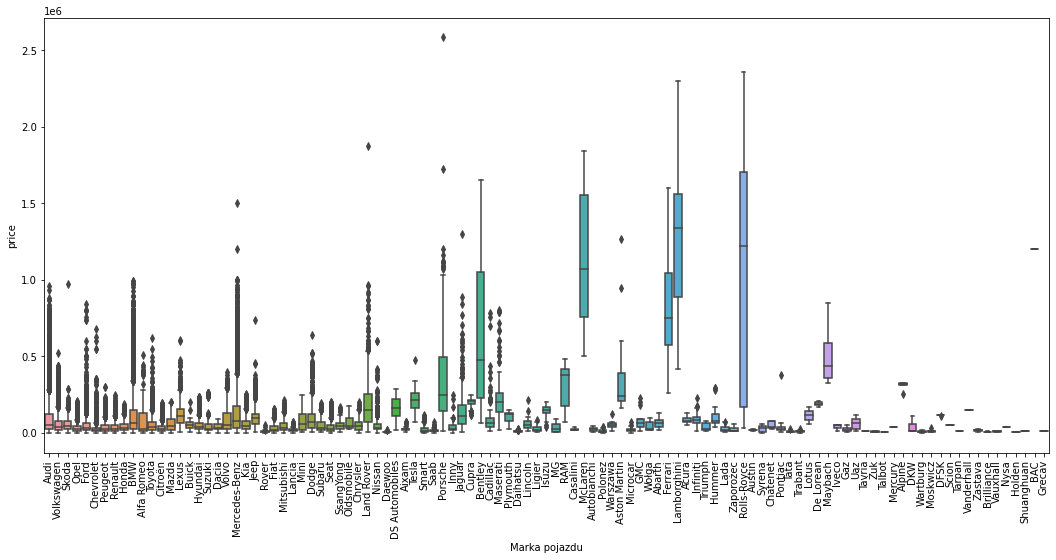

In [37]:
plt.figure(figsize=(18,8))
ax = sns.boxplot(x=X_train["Marka pojazdu"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

#### Year of production

In [38]:
ind = X_train.loc[X_train["Rok produkcji"] < 1920].index
X_train.loc[ind, ["href", "Marka pojazdu", "Model pojazdu", "Generacja", "Rok produkcji"]]

,href,Marka pojazdu,Model pojazdu,Generacja,Rok produkcji
58251,https://www.otomoto.pl/oferta/ford-focus-ford-focus-mk-lift-ii-1-8-tdci-ID6DzBxg.html,Ford,Focus,Mk2 (2004-2011),1908.0000


In [39]:
# Correct the data
X_train.loc[58251, "Rok produkcji"] = 2008    # based on generation

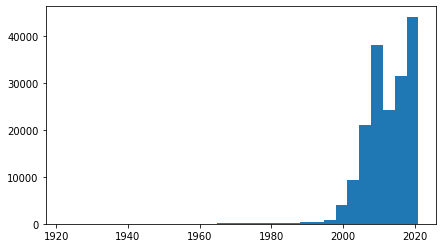

In [40]:
# Histogram for production year
plt.figure(figsize=(7,4))
plt.hist(X_train["Rok produkcji"], bins=30)
plt.show()

#### Mileage

Check offers with outlier mileage:

In [41]:
# Outliers
ind = X_train.loc[X_train["Przebieg"] > 2500000].index
X_train.loc[ind, ["href", "seller_name", "Marka pojazdu", "Rok produkcji", "Przebieg"]]

,href,seller_name,Marka pojazdu,Rok produkcji,Przebieg
178922,https://www.otomoto.pl/oferta/volkswagen-caravelle-zarezerwowane-zarezerwowane-zarezerwowane-ID6DznE8.html,Caravelle 2 x drzwi boczne,Volkswagen,2006.0000,3999999.0000
113016,https://www.otomoto.pl/oferta/opel-kadett-piekny-zabytkowy-model-ID6D9eld.html,P.P.U.H Andrzej Rybarczyk,Opel,1937.0000,1111111111.0000
122978,https://www.otomoto.pl/oferta/peugeot-407-peugeot-407-1-6hdi-nawi-2007r-ID6DA8be.html,Sylwester,Peugeot,2007.0000,3330000.0000
11530,https://www.otomoto.pl/oferta/audi-a6-1-9-tdi-a6-klima-z-niemiec-ID6DATuu.html,Anonymous,Audi,1999.0000,10000000.0000
34937,https://www.otomoto.pl/oferta/citroen-jumpy-combi-9-osobowy-z-niemiec-ID6DyVz4.html,Tomasz,Citroën,2006.0000,99999999999.0000
34451,https://www.otomoto.pl/oferta/citroen-citroen-hy-foodtruck-lodziarnia-reklama-twojej-firmy-ID6Ddefj.html,hy,Citroën,1978.0000,11111111.0000
30879,https://www.otomoto.pl/oferta/bmw-m3-m3-e46-gotowa-odswiezona-buda-wyscigi-wyscigowka-klatka-laminaty-ID6DABJn.html,Paweł,BMW,2003.0000,11111111.0000
27401,https://www.otomoto.pl/oferta/bmw-seria-5-bmw-520-d-m-pakiet-ID6DylFM.html,KRZYSZTOF,BMW,2008.0000,2787777.0000
141033,https://www.otomoto.pl/oferta/renault-oryginalne-dauphine-gordini-ID6D4Mc8.html,P.P.H.U.,Renault,1964.0000,100000000.0000
124883,https://www.otomoto.pl/oferta/peugeot-607-okazja-peugeot-607-2-0-b-pelna-wersja-zadbany-ID6DAKvg.html,gosia,Peugeot,2001.0000,3075000.0000


In [42]:
# Remove
X_train = X_train.drop(index=ind).copy()
y_train = y_train.drop(index=ind).copy()

##### Mileage dependence on the year of production

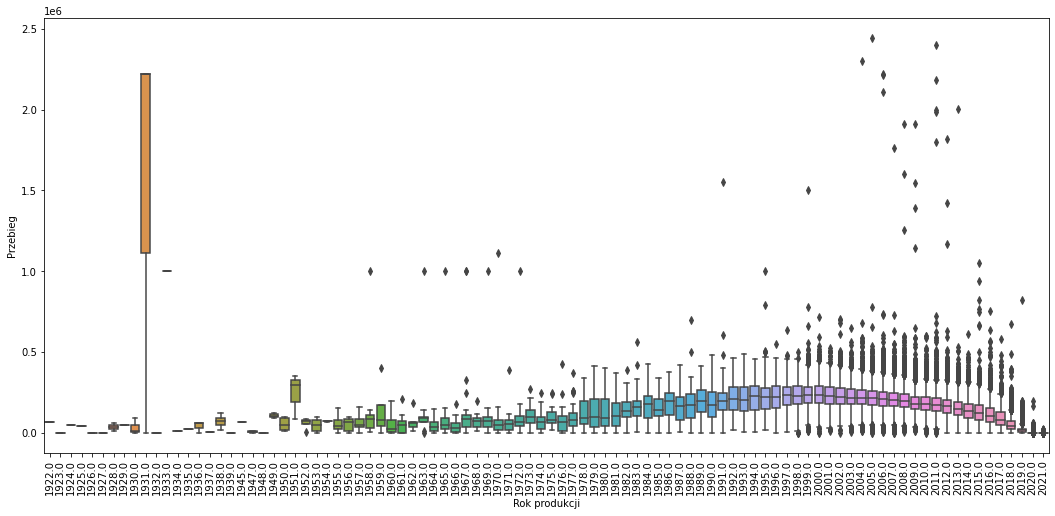

In [43]:
plt.figure(figsize=(18,8))
ax = sns.boxplot(x=X_train["Rok produkcji"], y=X_train["Przebieg"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

#### Car engine capacity

In [44]:
X_train.join(y_train).loc[X_train["Pojemność skokowa"] > 7000, \
                         ["href", "Pojemność skokowa", "Moc", "Marka pojazdu", "Rok produkcji", "price"]]

,href,Pojemność skokowa,Moc,Marka pojazdu,Rok produkcji,price
82779,https://www.otomoto.pl/oferta/lincoln-mark-lincoln-mark-iii-1969-r-w-pieknym-oryginalnym-stanie-ID6DuFV7.html,7536.0000,365.0000,Lincoln,1969.0000,88000.0000
31377,https://www.otomoto.pl/oferta/cadillac-eldorado-eldorado-100-oryginal-nie-naprawiany-org-lakier-ID6DwvYr.html,8200.0000,234.0000,Cadillac,1972.0000,32999.0000
82750,https://www.otomoto.pl/oferta/lincoln-mark-lincoln-continental-mark-iv-1976-ID6DzNCs.html,8000.0000,225.0000,Lincoln,1976.0000,45000.0000
82748,https://www.otomoto.pl/oferta/lincoln-continental-zabytkowy-lincoln-continental-72-idealny-stan-ID6BWUPC.html,7539.0000,222.0000,Lincoln,1972.0000,95000.0000
31329,https://www.otomoto.pl/oferta/buick-centurion-1972-buick-centuriun-lesabres-bigblock-v8-ID6DyuSx.html,7456.0000,250.0000,Buick,1972.0000,43000.0000
56543,https://www.otomoto.pl/oferta/ford-econoline-ID6CBRQ6.html,7600.0000,1.0000,Ford,1997.0000,72000.0000
31376,https://www.otomoto.pl/oferta/cadillac-deville-cadillac-deville-iv-7-7l-v8-dokumenty-palacy-jezdny-ID6DbRHb.html,7700.0000,200.0000,Cadillac,1973.0000,37900.0000
82786,https://www.otomoto.pl/oferta/lincoln-mark-lincoln-mark-iii-1969-ID6DAMme.html,7596.0000,340.0000,Lincoln,1969.0000,35500.0000
31399,https://www.otomoto.pl/oferta/cadillac-deville-cadillac-deville-oferta-prywatna-ID6D8GgA.html,8190.0000,193.0000,Cadillac,1974.0000,77000.0000
42919,https://www.otomoto.pl/oferta/dodge-viper-gts-acr-v10-super-ID6Ddw7s.html,7990.0000,450.0000,Dodge,1999.0000,270000.0000


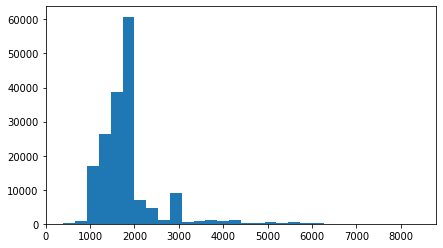

In [45]:
# Engine capacity
plt.figure(figsize=(7,4))
plt.hist(X_train["Pojemność skokowa"], bins=30)
plt.show()

#### Car engine power

In [46]:
X_train.join(y_train).loc[X_train["Moc"] > 750, \
                         ["href", "Pojemność skokowa", "Moc", "Marka pojazdu", "Rok produkcji", "price"]]

,href,Pojemność skokowa,Moc,Marka pojazdu,Rok produkcji,price
52953,https://www.otomoto.pl/oferta/ford-mustang-shelby-gt500-carbon-fibre-track-oficjalny-dealer-shelby-polska-ID6DyiZs.html,5163.0000,760.0000,Ford,2020.0000,759900.0000
130497,https://www.otomoto.pl/oferta/porsche-taycan-turbo-s-samochod-demonstracyjny-salonu-ID6DmXAM.html,NaN,761.0000,Porsche,2020.0000,829741.0000
43254,https://www.otomoto.pl/oferta/ferrari-812-superfast-jbl-lift-daytona-carbon-s-polska-f-vat-23-ID6DxriE.html,6500.0000,800.0000,Ferrari,2018.0000,1499000.0000
153224,https://www.otomoto.pl/oferta/skoda-fabia-tsi-lift-kombi-po-oplatach-ID6CRx4B.html,1200.0000,1200.0000,Škoda,2013.0000,16900.0000
130609,https://www.otomoto.pl/oferta/porsche-taycan-ID6DAHh8.html,NaN,761.0000,Porsche,2020.0000,969831.0000
37782,https://www.otomoto.pl/oferta/citroen-c4-picasso-2-0-benz-140-km-pelen-servis-ID6DrGXX.html,2000.0000,1400.0000,Citroën,2008.0000,16700.0000
49990,https://www.otomoto.pl/oferta/ford-fiesta-ID6DBxPx.html,1450.0000,1499.0000,Ford,2014.0000,19900.0000
42632,https://www.otomoto.pl/oferta/dodge-charger-dodge-charger-hellcat-zamiana-ID6Dr8To.html,6166.0000,850.0000,Dodge,2015.0000,259000.0000
54909,https://www.otomoto.pl/oferta/ford-f150-shelby-f150-super-snake-oficjalny-dealer-shelby-polska-ID6DB6fl.html,5000.0000,770.0000,Ford,2020.0000,799999.0000
42969,https://www.otomoto.pl/oferta/dodge-challenger-hellcat-2020-6-2l-porysowany-lakier-ID6DAgeu.html,6200.0000,797.0000,Dodge,2020.0000,295000.0000


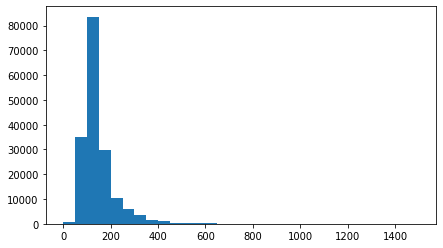

In [47]:
# Engine power
plt.figure(figsize=(7,4))
plt.hist(X_train["Moc"], bins=30)
plt.show()

Some high values of engine power are result of errors in data. These errors will be corrected at the data transformation stage.

In [48]:
# Correct the value for Peugeot Partner 
# (this value can't be corrected like others, because there are only two cars like that in the data)
X_train.loc[123161, "Moc"] = 100  # instead of 1499

#### CO2 emission

In [49]:
ind = X_train.loc[X_train["Emisja CO2"] > 1000].index
X_train.loc[ind, ["href", "Emisja CO2", "Pojemność skokowa", "Moc", "Marka pojazdu", "Rok produkcji"]]

,href,Emisja CO2,Pojemność skokowa,Moc,Marka pojazdu,Rok produkcji
147879,https://www.otomoto.pl/oferta/skoda-octavia-iv-combi-style-1-5-tsi-ID6DBg6H.html,123153.0000,1498.0000,150.0000,Škoda,2020.0000
151644,https://www.otomoto.pl/oferta/skoda-octavia-iv-combi-style-1-5-tsi-ID6DBqtD.html,123134.0000,1498.0000,150.0000,Škoda,2021.0000
152810,https://www.otomoto.pl/oferta/skoda-octavia-iv-combi-style-1-5-tsi-ID6DBqk7.html,123134.0000,1498.0000,150.0000,Škoda,2021.0000
44076,https://www.otomoto.pl/oferta/fiat-126-fiat-126-elx-po-remoncie-ID6DztNI.html,1234.0000,652.0000,24.0000,Fiat,1998.0000
10661,https://www.otomoto.pl/oferta/audi-a3-audi-a3-1-9-tdi-2007r-3d-boleslawiec-dolny-slask-ID6DAg52.html,1900.0000,1896.0000,105.0000,Audi,2006.0000
152792,https://www.otomoto.pl/oferta/skoda-octavia-iv-combi-style-1-5-tsi-ID6DBqs9.html,123134.0000,1498.0000,150.0000,Škoda,2021.0000


In [50]:
# This column contains multiple NaN values; further proceedings to be decided
X_train.loc[ind, "Emisja CO2"] = np.NaN

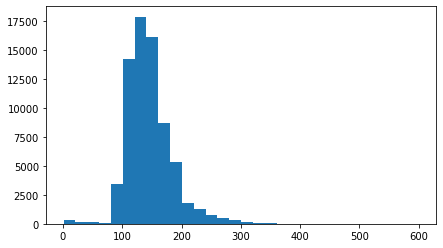

In [51]:
# CO2 emission
plt.figure(figsize=(7,4))
plt.hist(X_train["Emisja CO2"], bins=30)
plt.show()

#### Number of doors

In [52]:
# Number of doors
ind = X_train.loc[X_train["Liczba drzwi"] > 10].index
X_train.loc[ind, ["href", "Liczba drzwi", "Liczba miejsc", "Marka pojazdu"]]

,href,Liczba drzwi,Liczba miejsc,Marka pojazdu
129275,https://www.otomoto.pl/oferta/peugeot-2008-benz-automat-gwarancja-oplacony-ID6DB4WW.html,50.0000,5.0000,Peugeot
186863,https://www.otomoto.pl/oferta/volvo-s90-dealer-volvo-karlik-poznan-malta-ID6DgqEl.html,55.0000,5.0000,Volvo
9585,https://www.otomoto.pl/oferta/audi-a3-1-5-tfsi-150-km-s-tronic-2-strefy-alarm-salon-pl-audi-centrum-wroclaw-ID6Dy6Dx.html,53.0000,5.0000,Audi


In [53]:
# Correct the above outliers
X_train.loc[ind, "Liczba drzwi"] = X_train["Liczba drzwi"].median()

In [54]:
X_train["Liczba drzwi"].value_counts(dropna=False) 

5.0000     136021
4.0000      22243
3.0000       9392
2.0000       4669
NaN          2604
6.0000         68
7.0000          3
8.0000          2
9.0000          1
10.0000         1
1.0000          1
Name: Liczba drzwi, dtype: int64

##### Price dependense on the number of doors

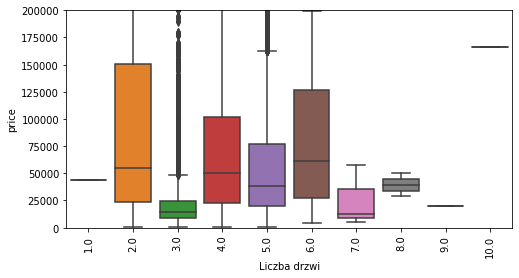

In [55]:
# Number of doors
plt.figure(figsize=(8,4))
ax = sns.boxplot(x=X_train["Liczba drzwi"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=200000)
plt.show()

#### Number of seats

In [56]:
X_train["Liczba miejsc"].value_counts(dropna=False) 

5.0000    143425
NaN        11206
4.0000      8465
7.0000      7244
2.0000      1693
9.0000      1138
8.0000       691
6.0000       600
3.0000       529
1.0000        14
Name: Liczba miejsc, dtype: int64

##### Price dependense on the number of seats

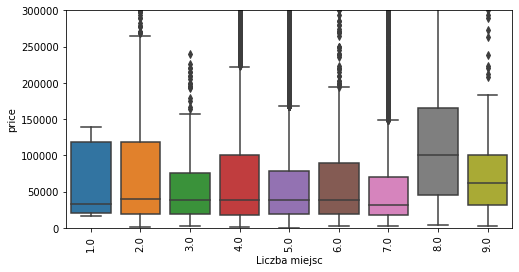

In [57]:
# Number of seats
plt.figure(figsize=(8,4))
ax = sns.boxplot(x=X_train["Liczba miejsc"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=300000)
plt.show()

### Summary after removing outliers

In [58]:
X_train.describe()

,Rok produkcji,Przebieg,Pojemność skokowa,Moc,Liczba drzwi,Liczba miejsc,Emisja CO2
count,175005.0000,173929.0000,173143.0000,173840.0000,172401.0000,163799.0000,71511.0000
mean,2012.4208,132289.1245,1860.6453,151.1549,4.6813,5.0431,146.0316
std,6.5013,97888.8763,701.5024,76.3813,0.7000,0.6977,38.9539
min,1922.0000,1.0000,400.0000,1.0000,1.0000,1.0000,1.0000
25%,2008.0000,44100.0000,1461.0000,105.0000,5.0000,5.0000,120.0000
50%,2013.0000,138758.0000,1796.0000,136.0000,5.0000,5.0000,140.0000
75%,2018.0000,199000.0000,1997.0000,170.0000,5.0000,5.0000,163.0000
max,2021.0000,2444444.0000,8400.0000,1499.0000,10.0000,9.0000,600.0000


### [Save a checkpoint]

In [59]:
# Dump X_train and y_train to pickle
with open("/".join([path, "X_train_1.obj"]), "wb") as fp:
    pickle.dump(X_train, fp)
    
with open("/".join([path, "y_train_1.obj"]), "wb") as fp:
    pickle.dump(y_train, fp)

In [60]:
# Dump X_test and y_test to pickle
with open("/".join([path, "X_test_1.obj"]), "wb") as fp:
    pickle.dump(X_test, fp)
    
with open("/".join([path, "y_test_1.obj"]), "wb") as fp:
    pickle.dump(y_test, fp)

In [61]:
# Read X_train and y_train from pickle 
with open("/".join([path, "X_train_1.obj"]), 'rb') as fp:
    X_train = pickle.load(fp)
    
with open("/".join([path, "y_train_1.obj"]), 'rb') as fp:
    y_train = pickle.load(fp)

## Data transformation
Data transformation before machine learning.

### Auxiliary functions and classes

In [62]:
# Count threshold as n * median (to use in agg(...) method)
def threshold(n, label=None):
    def threshold_(x):
        return np.NaN if x.isna().all() else np.nanmedian(x, axis=0) * n
    threshold_.__name__ = (label if label is not None else 'threshold_%s' % n)
    return threshold_

# Get value from DataFrame with multi-index (but simple-index is also supported)
def multi_index_value(df, ind, val):
    """
    Parameters: 
    df = DataFrame
    ind = multi-index or simple-index (for multi-index: for example a row from X[["col1, col2, col3"]])
    val = column or multi-column (fot multi-column: for example "('col', 'median')")
    """
    if isinstance(df.index, pd.MultiIndex):
        return df.loc[tuple([item for item in ind]), val]
    else:
        return df.loc[ind, val]

In [63]:
class HierarchicalColumnsUnifier(BaseEstimator, TransformerMixin):
    """
    Transformer unifies hierarchical fields in a way that allows them to be grouped effectively.
    Parent columns: columns in hierarchical order.
    Child columns: columns subordinate to the parents, but without any established hierarchy among themselves.
    """
    
    def __init__(self, parent_columns, child_columns = [], unknown_value = "other"): 
        self.parent_columns = parent_columns
        self.child_columns = child_columns
        self.unknown_value = unknown_value
    
    
    def fit(self, X, y=None):       
        return self

    
    def transform(self, X, y=None):
        
        # Change to small letters and fill NaNs        
        for c in self.parent_columns + self.child_columns:
            X[c] = X[c].fillna(self.unknown_value).apply(lambda x: x.lower())
        
        # For example, if car brand is unknown, set also car model = unknown
        parent = self.parent_columns[0]
        for c in self.parent_columns[1:]:
            X.loc[X[parent] == self.unknown_value, c] = self.unknown_value
            parent = c
        
        # For example, if car model is unknown, set also version and generation = unknown
        for c in self.child_columns:
            X.loc[X[parent] == self.unknown_value, c] = self.unknown_value
        
        return X

### Preprocessing

In [64]:
class OtoMotoPreprocessor(BaseEstimator, TransformerMixin):
    """
    Preprocessor dedicated for OtoMoto data:
    - standardizes binary fields,
    - all fields related to warranty reduces to one field,
    - divides the field "price_details" into its components,
    - creates new column "gas", 
    - marges similar categories in the field "Rodzaj paliwa" and writes new categories to "fuel",
    - marges similar categories in the field "Napęd",
    - rescales engine capacity and sets capacity = 0 for electric cars, 
    - calls HierarchicalColumnsUnifier for brands, models, generations and versions,
    - fills NaNs (except number fields).
    """
    
    # Type of fuel: according to this dictionary similar categories will be marged
    fuel_dict_ = {    
                      "Benzyna":     "Benzyna",    
                      "Benzyna+LPG": "Benzyna",
                      "Benzyna+CNG": "Benzyna",
                      "Diesel":      "Diesel",
                      "Hybryda":     "Hybryda",
                      "Elektryczny": "Elektryczny"
                   }
    
    # Type of drive: according to this dictionary similar categories will be marged
    drive_dict_ = {
                      "Na przednie koła":              "Na przednie koła",
                      "4x4 (stały)":                   "4x4 (stały)",
                      "Na tylne koła":                 "Na tylne koła",
                      "4x4 (dołączany automatycznie)": "4x4 (dołączany automatycznie)",
                      "4x4 (dołączany ręcznie)":       "Na tylne koła"
                   }

    # Binary columns
    bin_columns_ = [ 'Faktura VAT', 'Zarejestrowany w Polsce', 'Pierwszy właściciel', 'Bezwypadkowy', 'Serwisowany w ASO', \
                     'Metalik', 'ABS', 'Bluetooth', 'Czujnik zmierzchu', 'Elektrycznie ustawiane lusterka', 'Gniazdo USB', \
                     'Klimatyzacja automatyczna', 'MP3', 'Poduszka powietrzna chroniąca kolana', 'Poduszki boczne przednie', \
                     'Radio niefabryczne', 'Światła do jazdy dziennej', 'Szyberdach', 'Alufelgi', 'Centralny zamek', \
                     'Czujniki parkowania tylne', 'ESP (stabilizacja toru jazdy)', 'Immobilizer', 'Komputer pokładowy', \
                     'Ogranicznik prędkości', 'Poduszka powietrzna kierowcy', 'Poduszki boczne tylne', 'Radio fabryczne', \
                     'Światła LED', 'Wielofunkcyjna kierownica', 'ASR (kontrola trakcji)', 'Czujnik deszczu', \
                     'Elektryczne szyby przednie', 'Gniazdo AUX', 'Isofix', 'Kurtyny powietrzne', 'Podgrzewane lusterka boczne', \
                     'Poduszka powietrzna pasażera', 'Przyciemniane szyby', 'Światła Xenonowe', 'Światła przeciwmgielne', \
                     'Wspomaganie kierownicy', 'Perłowy', 'Tuning', 'Alarm', 'CD', 'Tapicerka welurowa', 'Gniazdo SD', 'Tempomat', \
                     'Dach panoramiczny', 'Podgrzewana przednia szyba', 'Klimatyzacja manualna', 'System Start-Stop', \
                     'Akryl (niemetalizowany)', 'VAT marża', 'Asystent parkowania', 'Klimatyzacja dwustrefowa', \
                     'Regulowane zawieszenie', 'Nawigacja GPS', 'Tapicerka skórzana', 'Elektrochromatyczne lusterko wsteczne', \
                     'Czujniki parkowania przednie', 'Kamera cofania', 'Odtwarzacz DVD', 'Podgrzewane przednie siedzenia', \
                     'Elektrochromatyczne lusterka boczne', 'Tuner TV', 'Łopatki zmiany biegów', 'Elektryczne szyby tylne', \
                     'Elektrycznie ustawiane fotele', 'Klimatyzacja czterostrefowa', 'Asystent pasa ruchu', 'Czujnik martwego pola', \
                     'Zmieniarka CD', 'Relingi dachowe', 'Hak', 'Tempomat aktywny', 'Podgrzewane tylne siedzenia', \
                     'Kierownica po prawej (Anglik)', 'Ogrzewanie postojowe', 'Filtr cząstek stałych', 'HUD (wyświetlacz przezierny)', \
                     'first_reg_flg', 'gas', 'Możliwość odliczenia VAT', 'Do negocjacji', 'warranty', 'Uszkodzony', \
                     'Warranty if agreed with the buyer', 'Zarejestrowany jako zabytek', 'Kierownica po prawej (Anglik)', \
                     'Matowy', 'Homologacja ciężarowa']   

    # Values appearing in column "price_details", separated by commas
    price_details_ = ["Możliwość odliczenia VAT", "Do negocjacji", "Faktura VAT"] 

    # Default values
    fuel_default_ = "Benzyna"
    drive_default_ = "Na przednie koła" 
    gearbox_default_ = "Manualna" 
    car_type_default_ = "Auta miejskie"
    seller_default_ = "Osoba prywatna"
    doors_default_ = 5 
    seats_default_ = 5

    
    def __init__(self, max_year=2021):    
        # Year for which the data is valid (notice: model requires periodic update)
        self.max_year_ = max_year     

        pass
        
            
    def fit(self, X, y=None):     
        # Values in the training set
        self.fuel_list_ = X["Rodzaj paliwa"].unique()
        self.drive_list_ = X["Napęd"].unique()
        self.car_type_list_ = X["Typ"].unique()
        self.seller_type_list_ = X["seller_type"].unique()

        # Prepare HierarchicalColumnsUnifier
        self.hierarchical_columns_unifier = HierarchicalColumnsUnifier(\
                                            parent_columns = ["Marka pojazdu", "Model pojazdu"], \
                                            child_columns = ["Generacja", "Wersja"], \
                                            unknown_value = "inny")
        self.hierarchical_columns_unifier.fit(X, y)
        
        return self

    
    def transform(self, X, y=None):
        # Change year of car production to age (new column)
        X["age"] = self.max_year_ - X["Rok produkcji"]

        # All new cars are accident-free
        X.loc[X["Stan"] == "Nowe", "Bezwypadkowy"] = "Tak"
                 
        # Correct atypical values
        X.loc[X["Matowy"] == "matt", "Matowy"] = "Tak"
        X.loc[X["Metalik"] == "metallic", "Metalik"] = "Tak"
        X.loc[X["Akryl (niemetalizowany)"] == "acrylic", "Akryl (niemetalizowany)"] = "Tak"
        X.loc[X["Kierownica po prawej (Anglik)"] == "true", "Kierownica po prawej (Anglik)"] = "Tak"    
                      
        # Change binary columns with values "Tak"/"Nie"/np.NaN to int: 1, 0         
        for c in self.bin_columns_:
            if c in X.columns:
                X[c].fillna("0", inplace=True)
                X[c].replace(to_replace="^(Tak|tak|true|1).*", value="1", regex=True, inplace=True)
                X[c].replace(to_replace="^(?!Tak|tak|true|1).*", value="0", regex=True, inplace=True)
                X[c] = X[c].astype("int8")
        
        # Change date of the first registration to first_reg_flg (new column):
        # first_reg_flg = 1, if the car was registered in a year later than the year of production.
        X.loc[X["Pierwsza rejestracja"].notna(), "first_reg_flg"] = X.loc[X["Pierwsza rejestracja"].notna()].\
                                                                    apply(self.__get_first_reg_flg, axis="columns")    
        X["first_reg_flg"].fillna(0, inplace=True)
        X["first_reg_flg"] = X["first_reg_flg"].astype("int8")

        # Check if there are new values in the set that did not occur in the training set
        new_val = [val for val in X["Rodzaj paliwa"].unique() if val not in self.fuel_list_]
        if len(new_val) > 0: X["Rodzaj paliwa"].replace(to_replace=new_val, value=self.fuel_default_, inplace=True) 
        new_val = [val for val in X["Napęd"].unique() if val not in self.drive_list_]
        if len(new_val) > 0: X["Napęd"].replace(to_replace=new_val, value=self.drive_default_, inplace=True)  
        new_val = [val for val in X["Typ"].unique() if val not in self.car_type_list_]
        if len(new_val) > 0: X["Typ"].replace(to_replace=new_val, value=self.car_type_default_, inplace=True)  
        new_val = [val for val in X["seller_type"].unique() if val not in self.seller_type_list_]
        if len(new_val) > 0: X["seller_type"].replace(to_replace=new_val, value=self.seller_default_, inplace=True)  
        
        # Gas installation (new column)
        X["gas"] = X.apply(lambda x: 0 if re.search("LPG|CNG", x["Rodzaj paliwa"]) is None else 1, axis="columns")
        X["gas"].fillna(0, inplace=True)
        X["gas"] = X["gas"].astype("int8")
        
        # Type of fuel: take category from dictionary and fill NaNs with default value
        X["fuel"] = X["Rodzaj paliwa"].apply(lambda x: self.fuel_dict_.get(x, self.fuel_default_))
        X["fuel"].fillna(self.fuel_default_, inplace=True)
                 
        # Type of drive: take category from dictionary and fill NaNs with default value
        X["Napęd"] = X["Napęd"].apply(lambda x: self.drive_dict_.get(x, self.drive_default_))
        X["Napęd"].fillna(self.drive_default_, inplace=True)  
                 
        # Gearbox: fill NaNs with default value, transform to binary, change type to int8,
        # prevent the appearance of additional values in new data
        X["Skrzynia biegów"].fillna(self.gearbox_default_, inplace=True)
        """
        X["Skrzynia biegów"].replace(to_replace="^(Manualna).*", value="1", regex=True, inplace=True)
        X["Skrzynia biegów"].replace(to_replace="^(?!Manualna).*", value="0", regex=True, inplace=True)
        X["Skrzynia biegów"] = X["Skrzynia biegów"].astype("int8")
        """

        # Condition (new / used): transform to binary, change type to int8,
        # prevent the appearance of additional values in new data
        """
        X["Stan"].replace(to_replace="^(Używane).*", value="1", regex=True, inplace=True)
        X["Stan"].replace(to_replace="^(?!Używane).*", value="0", regex=True, inplace=True)
        X["Stan"] = X["Stan"].astype("int8")
        """
        
        # Engine capacity:
        # Scale and round to get rid of small differences in capacities
        X["Pojemność skokowa"] = round(X["Pojemność skokowa"] / 100.0, 0).astype(float)
        # Set 0 for electric cars
        X.loc[X["Rodzaj paliwa"] == "Elektryczny", "Pojemność skokowa"] = 0.0  
        
        # Number of doors: fill NaNs with median
        X["Liczba drzwi"].fillna(self.doors_default_, inplace=True)
        # Change from numeric to categorical
        X["doors"] = X["Liczba drzwi"].astype(str)
        X.loc[X["Liczba drzwi"] <= 2, "doors"] = "<=2" # only one car has a value = 1 (append the value 1 to 2)
        X.loc[X["Liczba drzwi"] >= 5, "doors"] = ">=5" # only a few dozen cars have a value > 5 (append them to moda)
        
        # Number of seats: fill NaNs with median
        X["Liczba miejsc"].fillna(self.seats_default_, inplace=True)
        # Change from numeric to categorical
        X["seats"] = X["Liczba miejsc"].astype(str)
        X.loc[X["Liczba miejsc"] < 8, "seats"] = "<8"  # values < 8 have similar average price
        X.loc[X["Liczba miejsc"] >=8, "seats"] = ">=8" # values >=8 have higher average prices
        
        # Warranty: combine three fields related to the guarantee into one.
        X["warranty"] = (X["Gwarancja dealerska (w cenie)"].notna() | \
                         X["Okres gwarancji producenta"].notna() | \
                         X["lub do (przebieg km)"].notna()).astype("int8")

        # Price details: split them to three separate columns:
        for c in self.price_details_:
            X[c] = X["price_details"].apply(\
                   lambda x: int(c in re.split(", ", x if not pd.isnull(x) else ""))).astype("int8")
                
        # Unify hierarchical fields (brands, models, generations, versions) 
        X = self.hierarchical_columns_unifier.transform(X, y)             

        return X
    
    
    # Private method
    def __get_first_reg_flg(self, X):
        try:
            # Return 1, if the car was registered in a year later than the year of production
            return 1 if datetime.strptime(str(X["Pierwsza rejestracja"]), "%d/%m/%Y").year > X["Rok produkcji"] \
                   else 0
        except ValueError as ex:
            return np.NaN

In [65]:
otomoto_preprocessor = OtoMotoPreprocessor()

In [66]:
# Dump otomoto_preprocessor to pickle
with open("/".join([path, "OtoMotoPreprocesor.obj"]), "wb") as fp:
    pickle.dump(otomoto_preprocessor, fp)

In [67]:
X_train = otomoto_preprocessor.fit_transform(X_train, y_train)

Data check:

In [68]:
X_train.loc[X_train["Pierwsza rejestracja"].notna(), \
           ["Rok produkcji", "age", "Pierwsza rejestracja", "first_reg_flg"]].head()

,Rok produkcji,age,Pierwsza rejestracja,first_reg_flg
48371,2018.0000,3.0000,27/07/2018,0
127204,2008.0000,13.0000,26/03/2009,1
120930,2005.0000,16.0000,13/06/2005,0
147408,2009.0000,12.0000,10/01/2010,1
180887,2017.0000,4.0000,05/04/2017,0


In [69]:
X_train["age"].isna().any()

False

In [70]:
X_train["first_reg_flg"].value_counts(dropna=False)

0    165668
1      9337
Name: first_reg_flg, dtype: int64

In [71]:
X_train["gas"].value_counts(dropna=False)

0    167909
1      7096
Name: gas, dtype: int64

In [72]:
X_train["fuel"].value_counts(dropna=False)

Benzyna        94155
Diesel         75188
Hybryda         4750
Elektryczny      912
Name: fuel, dtype: int64

In [73]:
X_train[["fuel", "gas"]].head(20000).tail(5)

,fuel,gas
183618,Benzyna,0
142924,Benzyna,0
30427,Diesel,0
69749,Benzyna,1
180607,Elektryczny,0


In [74]:
# Engine capacity for electric car should be equal 0
X_train.loc[X_train["fuel"] == "Elektryczny", ["Pojemność skokowa"]].value_counts()

Pojemność skokowa
0.0000               912
dtype: int64

In [75]:
X_train["Napęd"].value_counts(dropna=False)

Na przednie koła                 131554
Na tylne koła                     15947
4x4 (stały)                       14002
4x4 (dołączany automatycznie)     13502
Name: Napęd, dtype: int64

In [76]:
X_train["doors"].value_counts(dropna=False) 

>=5    138700
4.0     22243
3.0      9392
<=2      4670
Name: doors, dtype: int64

In [77]:
X_train["seats"].value_counts(dropna=False) 

<8     173176
>=8      1829
Name: seats, dtype: int64

In [78]:
X_train["Skrzynia biegów"].value_counts(dropna=False) 

Manualna        113983
Automatyczna     61022
Name: Skrzynia biegów, dtype: int64

In [79]:
X_train["Stan"].value_counts(dropna=False) 

Używane    151874
Nowe        23131
Name: Stan, dtype: int64

In [80]:
X_train[["price_details"] + otomoto_preprocessor.price_details_ + ["VAT marża", "seller_type", "Stan"]].head(9000).tail(5)

,price_details,Możliwość odliczenia VAT,Do negocjacji,Faktura VAT,VAT marża,seller_type,Stan
67200,Do negocjacji,0,1,0,1,Dealer,Używane
57399,"Możliwość odliczenia VAT, Do negocjacji, Faktura VAT",1,1,1,0,Autoryzowany Dealer,Nowe
12097,NaN,0,0,0,0,Osoba prywatna,Używane
110520,Do negocjacji,0,1,0,1,Dealer,Używane
85165,Do negocjacji,0,1,0,0,Osoba prywatna,Używane


In [81]:
X_train[otomoto_preprocessor.price_details_ + ["VAT marża"]].sum()

Możliwość odliczenia VAT     7844
Do negocjacji               88862
Faktura VAT                 56317
VAT marża                   54778
dtype: int64

In [82]:
X_train["warranty"].value_counts(dropna=False)

0    162731
1     12274
Name: warranty, dtype: int64

In [83]:
X_train[otomoto_preprocessor.bin_columns_].head(4444).tail(5)

,Skrzynia biegów,Stan,Faktura VAT,Zarejestrowany w Polsce,Pierwszy właściciel,Bezwypadkowy,Serwisowany w ASO,Metalik,ABS,Bluetooth,Czujnik zmierzchu,Elektrycznie ustawiane lusterka,Gniazdo USB,Klimatyzacja automatyczna,MP3,Poduszka powietrzna chroniąca kolana,Poduszki boczne przednie,Radio niefabryczne,Światła do jazdy dziennej,Szyberdach,Alufelgi,Centralny zamek,Czujniki parkowania tylne,ESP (stabilizacja toru jazdy),Immobilizer,Komputer pokładowy,Ogranicznik prędkości,Poduszka powietrzna kierowcy,Poduszki boczne tylne,Radio fabryczne,Światła LED,Wielofunkcyjna kierownica,ASR (kontrola trakcji),Czujnik deszczu,Elektryczne szyby przednie,Gniazdo AUX,Isofix,Kurtyny powietrzne,Podgrzewane lusterka boczne,Poduszka powietrzna pasażera,Przyciemniane szyby,Światła Xenonowe,Światła przeciwmgielne,Wspomaganie kierownicy,Perłowy,Tuning,Alarm,CD,Tapicerka welurowa,Gniazdo SD,Tempomat,Dach panoramiczny,Podgrzewana przednia szyba,Klimatyzacja manualna,System Start-Stop,Akryl (niemetalizowany),VAT marża,Asystent parkowania,Klimatyzacja dwustrefowa,Regulowane zawieszenie,Nawigacja GPS,Tapicerka skórzana,Elektrochromatyczne lusterko wsteczne,Czujniki parkowania przednie,Kamera cofania,Odtwarzacz DVD,Podgrzewane przednie siedzenia,Elektrochromatyczne lusterka boczne,Tuner TV,Łopatki zmiany biegów,Elektryczne szyby tylne,Elektrycznie ustawiane fotele,Klimatyzacja czterostrefowa,Asystent pasa ruchu,Czujnik martwego pola,Zmieniarka CD,Relingi dachowe,Hak,Tempomat aktywny,Podgrzewane tylne siedzenia,Kierownica po prawej (Anglik),Ogrzewanie postojowe,Filtr cząstek stałych,HUD (wyświetlacz przezierny),first_reg_flg,gas,Możliwość odliczenia VAT,Do negocjacji,warranty,Uszkodzony,Warranty if agreed with the buyer,Zarejestrowany jako zabytek,Kierownica po prawej (Anglik),Matowy,Homologacja ciężarowa
190931,Manualna,Używane,0,1,0,0,0,0,1,1,1,1,1,1,0,0,1,0,1,0,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,0,1,0,0,1,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
59747,Manualna,Nowe,1,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,1,1,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
166863,Manualna,Używane,0,1,0,0,1,1,1,0,0,1,1,0,1,0,1,0,0,0,1,1,1,1,1,1,0,1,0,1,0,1,1,0,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
182890,Automatyczna,Używane,0,1,1,1,0,1,1,1,1,1,1,0,1,0,0,0,1,0,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
119912,Manualna,Używane,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0,1,0,1,1,0,0,1,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [84]:
with pd.option_context("display.max_rows", X_train.shape[1]):
    print(X_train[otomoto_preprocessor.bin_columns_].sum().sort_values(ascending=True))
    
# Columns to be removed due to low data volume:
# Uszkodzony                                    0
# Warranty if agreed with the buyer            22
# Zarejestrowany jako zabytek                 184
# Kierownica po prawej (Anglik)               375
# Matowy                                      674
# Homologacja ciężarowa                       798

Uszkodzony                                    0
Warranty if agreed with the buyer            22
Zarejestrowany jako zabytek                 184
Kierownica po prawej (Anglik)               375
Kierownica po prawej (Anglik)               375
Matowy                                      674
Homologacja ciężarowa                       798
Tuning                                     1015
Tuner TV                                   2639
Ogrzewanie postojowe                       5834
Radio niefabryczne                         6629
gas                                        7096
HUD (wyświetlacz przezierny)               7332
Możliwość odliczenia VAT                   7844
Klimatyzacja czterostrefowa                8095
Akryl (niemetalizowany)                    8477
Podgrzewane tylne siedzenia                8735
Regulowane zawieszenie                     8752
first_reg_flg                              9337
warranty                                  12274
Filtr cząstek stałych                   

In [85]:
X_train["Marka pojazdu"].isna().any(), \
X_train["Model pojazdu"].isna().any(), \
X_train["Generacja"].isna().any(), \
X_train["Wersja"].isna().any()

(False, False, False, False)

In [86]:
# Brands, models, generations and versions after HierarchicalColumnsUnifier transformation
X_train.loc[X_train["Model pojazdu"] != "inny", ["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja"]].head(3).append(\
X_train.loc[X_train["Model pojazdu"] == "inny", ["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja"]].head(2))

,Marka pojazdu,Model pojazdu,Generacja,Wersja
14515,audi,a6,c6 (2004-2011),inny
175904,volkswagen,passat,b8 (2014-),inny
155128,škoda,fabia,iii (2014-),1.0 ambition
43193,ds automobiles,inny,inny,inny
121851,inny,inny,inny,inny


Later, small categories (brands, models, generations and versions) will be combined with larger ones.

### Transformers

#### Engine capacity
Fill NaNs using a median for a given brand, model and fuel type.

In [87]:
class AggregateImputer(BaseEstimator, TransformerMixin):
    """
    Transformer counts the indicated aggregate for the column and uses it to fill NaNs. 
    If grouping_columns is given, aggregates for each group can be viewed in the statistics_ DataFrame. 
    If it is not posibble to count the aggregate for a group, alternative method can be used for filling NaNs 
    in statistics_.[aggragate], i.e. ‘backfill’, ‘bfill’, ‘pad’, ‘ffill’, as for the fillna method. 

    In the transform method, NaNs in X[column] are filled using the aggregate value counted for the group or, 
    if the appropriate group does not exist in statistics_, using the aggregate for whole Series.
    """
    
    def __init__(self, column, grouping_columns=None, aggregate="median", alternative=None):   
        self.column = column        
        self.grouping_columns = grouping_columns
        self.aggregate = aggregate    
        self.alternative = alternative
        
        
    def fit(self, X, y=None):              
        aggregates = ["count", "min", "max"]
        if self.aggregate not in aggregates:
            aggregates = aggregates + [self.aggregate]
        
        if isinstance(self.grouping_columns, list):
            columns = self.grouping_columns + [self.column]
            if len(self.grouping_columns) == 1:
                # self.grouping_columns should be a string, if it contains only 1 column  
                self.grouping_columns = self.grouping_columns[0]
        else:
            columns = [self.grouping_columns, self.column]

        # Calculate statistics for column
        if self.grouping_columns is not None:
            self.statistics_ = X[columns].groupby(self.grouping_columns).agg(aggregates)
            if self.alternative is not None:
                self.statistics_.fillna(method=self.alternative, inplace=True)
        
        # And count for all rows:
        self.agg_value_ = X[self.column].agg(self.aggregate)
        
        return self

    
    def transform(self, X, y=None):  
        if not X[self.column].isna().any():
            return X
        
        # Set aggregate of given group      
        if self.grouping_columns is not None:            
            X[self.column].fillna(X.loc[X[self.column].isna()].apply(lambda x: \
                       multi_index_value(self.statistics_, x[self.grouping_columns], (self.column, self.aggregate)),\
                       axis="columns"), inplace=True)

        # And for remaining NaNs 
        X[self.column].fillna(self.agg_value_, inplace=True)
        
        return X

In [88]:
capacity_imputer = AggregateImputer(column="Pojemność skokowa",\
                                    grouping_columns=["Marka pojazdu", "Model pojazdu", "fuel"],\
                                    aggregate="median")
X_train = capacity_imputer.fit_transform(X_train, y_train)

Data check:

In [89]:
capacity_imputer.statistics_.head(100).tail(5)

Pojemność skokowa                        
                                                count     min     max  median
Marka pojazdu Model pojazdu fuel                                             
audi          inny          Diesel                  1 30.0000 30.0000 30.0000
              q2            Benzyna                85 10.0000 20.0000 15.0000
                            Diesel                 13 16.0000 20.0000 16.0000
              q3            Benzyna               205 14.0000 25.0000 15.0000
                            Diesel                148 20.0000 20.0000 20.0000

In [90]:
X_train["Pojemność skokowa"].isna().any()

False

#### Engine power
Some records have invalid values in this field. The discrepancies are large, so we want to not only fill NaNs but also correct unbelievable values.

We operate on two subsets of data:
- subset1 - brand, model, generation and version are known,
- subset2 - brand and model are known, generation or version are unknown.

It can be expected that cars of the same make, model, generation, version, type of fuel and capacity have the same engine power or similar. If generation and version are unknown, engine power may differ but still discrepancy should not be significant.

Through thresholds, we define the tolerance for discrepancies. We set thresholds:
- lower_limit = n_lower * median,
- upper_limit = n_upper * median,

where parameters n_lower, n_upper will be selected experimentally.

Discrepancies will be reduced using the median calculated separately for each group.

In [91]:
class DiscrepanciesReducer(BaseEstimator, TransformerMixin):
    """
    Transformer reduces discrepancies.  
    Through thresholds, we define the tolerance for discrepancies, by setting: 
    lower_threshold = n_lower * aggregate (medium or mean),
    upper_threshold = n_upper * aggregate (medium or mean).
    Values below the lower_threshold or above the upper_threshold will be changed to the aggregate (median or mean)
    calculated for the given group.
    If fillna=True, the transformer also fills NaNs in the groups for which the aggregate was calculated.
    """
    
    def __init__(self, column, grouping_columns, n_lower=1.0, n_upper=1.0, aggregate="median", fillna=True):   
        self.column = column        
        self.grouping_columns = grouping_columns
        self.aggregate = aggregate 
        self.n_lower = n_lower
        self.n_upper = n_upper
        self.fillna = fillna
        
        
    def fit(self, X, y=None):              
        aggregates = ["count", "min", "max"]
        if self.aggregate not in aggregates:
            aggregates = aggregates + [self.aggregate]
            
        # Calculate statistics
        self.statistics_ = pd.DataFrame(X.loc[:,self.grouping_columns + [self.column]].\
                                        groupby(self.grouping_columns).agg(aggregates + \
                                        [threshold(self.n_lower, "lower_threshold"),  \
                                         threshold(self.n_upper, "upper_threshold")]).to_records())
        return self

    
    def transform(self, X, y=None):  
        # Merge copy of X with self.statistics_
        X_tmp = X[self.grouping_columns + [self.column]].copy()
        X_tmp["index"] = X_tmp.index
        X_tmp = X_tmp.merge(self.statistics_, on=self.grouping_columns, how="left")
        X_tmp.set_index("index", inplace=True)
        
        # Correct ouliers  
        X_tmp.loc[(X_tmp[self.column] > X_tmp[str((self.column, "upper_threshold"))]) | \
                  (X_tmp[self.column] < X_tmp[str((self.column, "lower_threshold"))]), self.column] = \
        X_tmp.loc[(X_tmp[self.column] > X_tmp[str((self.column, "upper_threshold"))]) | \
                  (X_tmp[self.column] < X_tmp[str((self.column, "lower_threshold"))]), str((self.column, self.aggregate))]
        
        # Fill NaNs 
        if self.fillna:
            X_tmp[self.column].fillna(X_tmp[str((self.column, self.aggregate))], inplace=True)

        # Rewrite column from X_tmp to X
        X[self.column] = X_tmp[self.column]
        
        return X

In [92]:
class EnginePowerDiscrReducer(DiscrepanciesReducer):
    """
    Transformer reduces discrepancies for engine power and fills NaNs. 
    The operation will be performed independently on two subsets: 
    - subset1 - brand, model, generation and version are known,
    - subset2 - brand and model are known, generation or version are unknown.
    Transformer inherits from BaseEstimator and TransformerMixin via DiscrepanciesReducer.
    """  
    
    __column = "Moc"
    __grouping_columns_dict = {
        "subset1": ["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja", "fuel", "Pojemność skokowa"],
        "subset2": ["Marka pojazdu", "Model pojazdu", "fuel", "Pojemność skokowa"],
    }    
    
        
    def __init__(self, subset, n_lower, n_upper, aggregate="median"): 
        self.subset = subset
        self.columns = self.__grouping_columns_dict[subset] + [self.__column]
        DiscrepanciesReducer.__init__(self, column=self.__column, grouping_columns=self.__grouping_columns_dict[subset],\
                                      n_lower=n_lower, n_upper=n_upper, aggregate=aggregate, fillna=True)
                
        
    def fit(self, X, y=None):          
        DiscrepanciesReducer.fit(self, self.__get_subset(X))            
        return self

    
    def transform(self, X, y=None):        
        # Reduce discrepancies by DiscrepanciesReducer for a given subset
        X_subset = DiscrepanciesReducer.transform(self, self.__get_subset(X))
        # Rewrite subset to X
        X.loc[X_subset.index, self.__column] = X_subset[self.__column]
        return X
    
    
    # Private method returning subset1 or subset2
    def __get_subset(self, X):
        if self.subset == "subset1":
            return X.loc[(X["Generacja"] != "inny") & (X["Wersja"] != "inny"), self.columns].copy()
                       
        elif self.subset == "subset2":
            return X.loc[(X["Marka pojazdu"] != "inny") & (X["Model pojazdu"] != "inny") & \
                        ((X["Generacja"] == "inny") | (X["Wersja"] == "inny")), self.columns].copy()
        else:
            return None

In [93]:
n_lower = 0.5
n_upper = 2.5

# Subset 1: brand, model, generation and version are known
# Outliers and NaNs will be change to median
engine_power_discr_reducer1 = EnginePowerDiscrReducer(subset="subset1", n_lower=n_lower, n_upper=n_upper)
X_train = engine_power_discr_reducer1.fit_transform(X_train, y_train)

In [94]:
n_lower = 0.15
n_upper = 3

# Subset 2: brand and model are known, generation or version are unknown
# Outliers and NaNs will be change to median
engine_power_discr_reducer2 = EnginePowerDiscrReducer(subset="subset2", n_lower=n_lower, n_upper=n_upper)
X_train = engine_power_discr_reducer2.fit_transform(X_train, y_train)

In [95]:
# Remaining NaNs
aggregate_imputer = AggregateImputer(column="Moc", aggregate="median")
X_train = aggregate_imputer.fit_transform(X_train, y_train)

Data check:

In [96]:
# Statistics calculated for subset1:
statistics1 = engine_power_discr_reducer1.statistics_
statistics1.head()

,Marka pojazdu,Model pojazdu,Generacja,Wersja,fuel,Pojemność skokowa,"('Moc', 'count')","('Moc', 'min')","('Moc', 'max')","('Moc', 'median')","('Moc', 'lower_threshold')","('Moc', 'upper_threshold')"
0,alfa romeo,90,b2 (1984-1986),2.5 l v6 jetronic,Benzyna,25.0000,1,158.0000,158.0000,158.0000,79.0000,395.0000
1,audi,100,c3 (1982-1991),1.8 cc,Benzyna,18.0000,1,90.0000,90.0000,90.0000,45.0000,225.0000
2,audi,100,c3 (1982-1991),2.0,Benzyna,20.0000,1,116.0000,116.0000,116.0000,58.0000,290.0000
3,audi,100,c3 (1982-1991),2.0 e,Benzyna,20.0000,2,115.0000,115.0000,115.0000,57.5000,287.5000
4,audi,100,c4 (1991-1994),2.3 e,Benzyna,23.0000,1,133.0000,133.0000,133.0000,66.5000,332.5000


In [97]:
# Outliers for subset1 (for given parameters), which have been corrected:
outliers1 = statistics1[(statistics1["('Moc', 'max')"] > statistics1["('Moc', 'upper_threshold')"]) | \
                        (statistics1["('Moc', 'min')"] < statistics1["('Moc', 'lower_threshold')"])]
outliers1

,Marka pojazdu,Model pojazdu,Generacja,Wersja,fuel,Pojemność skokowa,"('Moc', 'count')","('Moc', 'min')","('Moc', 'max')","('Moc', 'median')","('Moc', 'lower_threshold')","('Moc', 'upper_threshold')"
10659,opel,meriva,ii (2010-),ii (2010-2017),Benzyna,14.0000,6,100.0000,1000.0000,120.0000,60.0000,300.0000
15060,volkswagen,golf,v (2003-2009),v (2003-2009),Benzyna,14.0000,5,75.0000,200.0000,170.0000,85.0000,425.0000


In [98]:
# Statistics calculated for subset2:
statistics2 = engine_power_discr_reducer2.statistics_
statistics2.head()

,Marka pojazdu,Model pojazdu,fuel,Pojemność skokowa,"('Moc', 'count')","('Moc', 'min')","('Moc', 'max')","('Moc', 'median')","('Moc', 'lower_threshold')","('Moc', 'upper_threshold')"
0,abarth,500,Benzyna,14.0000,8,140.0000,185.0000,162.5000,24.3750,487.5000
1,abarth,595,Benzyna,14.0000,16,145.0000,190.0000,160.0000,24.0000,480.0000
2,abarth,695,Benzyna,14.0000,3,165.0000,180.0000,180.0000,27.0000,540.0000
3,abarth,grande punto,Benzyna,14.0000,6,155.0000,185.0000,165.0000,24.7500,495.0000
4,acura,mdx,Benzyna,35.0000,2,300.0000,300.0000,300.0000,45.0000,900.0000


In [99]:
# Outliers for subset2 (for given parameters), which have been corrected:
outliers2 = statistics2[(statistics2["('Moc', 'max')"] > statistics2["('Moc', 'upper_threshold')"]) | \
                        (statistics2["('Moc', 'min')"] < statistics2["('Moc', 'lower_threshold')"])]
outliers2

,Marka pojazdu,Model pojazdu,fuel,Pojemność skokowa,"('Moc', 'count')","('Moc', 'min')","('Moc', 'max')","('Moc', 'median')","('Moc', 'lower_threshold')","('Moc', 'upper_threshold')"
15,aixam,city,Diesel,6.0000,3,5.0000,30.0000,6.0000,0.9000,18.0000
694,citroën,berlingo,Benzyna,16.0000,27,90.0000,1000.0000,110.0000,16.5000,330.0000
762,citroën,c4 picasso,Benzyna,20.0000,6,140.0000,1400.0000,140.0000,21.0000,420.0000
900,daewoo,lanos,Benzyna,15.0000,15,1.0000,100.0000,86.0000,12.9000,258.0000
916,daihatsu,materia,Benzyna,15.0000,7,101.0000,1000.0000,103.0000,15.4500,309.0000
1242,ford,fiesta,Diesel,14.0000,32,50.0000,1499.0000,68.0000,10.2000,204.0000
2332,mercedes-benz,klasa s,Benzyna,50.0000,27,2.0000,388.0000,280.0000,42.0000,840.0000
2419,mercedes-benz,w123,Benzyna,23.0000,13,1.0000,230.0000,120.0000,18.0000,360.0000
2717,opel,astra,Benzyna,14.0000,665,3.0000,150.0000,140.0000,21.0000,420.0000
2728,opel,astra,Diesel,17.0000,179,74.0000,1100.0000,110.0000,16.5000,330.0000


In [100]:
X_train["Moc"].isna().any()

False

In [101]:
X_train["Moc"].describe()

count   175005.0000
mean       151.0965
std         76.0627
min          1.0000
25%        105.0000
50%        136.0000
75%        170.0000
max       1236.0000
Name: Moc, dtype: float64

#### Mileage
Fill NaNs using a median for a given age of car. If median does not exist for the age, take last known median (alternatively linear regression would be good too).

In [102]:
mileage_imputer = AggregateImputer(column="Przebieg", grouping_columns="age", aggregate="median", alternative="ffill")
X_train = mileage_imputer.fit_transform(X_train, y_train)

Data check:

In [103]:
# Statistics calculated for mileage:
mileage_imputer.statistics_.head()

Przebieg                              
          count    min         max     median
age                                          
0.0000     4025 1.0000  25485.0000     5.0000
1.0000    21660 1.0000 200000.0000     5.0000
2.0000     9095 1.0000 820586.0000 16500.0000
3.0000     8312 1.0000 677215.0000 44098.5000
4.0000    11993 1.0000 580000.0000 82000.0000

In [104]:
X_train["Przebieg"].isna().any()

False

#### [Save a checkpoint]

In [105]:
# Dump X_train and y_train to pickle
with open("/".join([path, "X_train_2.obj"]), "wb") as fp:
    pickle.dump(X_train, fp)
    
with open("/".join([path, "y_train_2.obj"]), "wb") as fp:
    pickle.dump(y_train, fp)

In [106]:
# Read X_train and y_train from pickle 
with open("/".join([path, "X_train_2.obj"]), 'rb') as fp:
    X_train = pickle.load(fp)
    
with open("/".join([path, "y_train_2.obj"]), 'rb') as fp:
    y_train = pickle.load(fp)

#### Models of cars: join small classes with "inny"
Combine brands, models, generations and versions to obtain groups with a cardinality >= "min_size".

Notice: versions, generations and models with the same name, belonging to different parents, are not the same. 
Their names will be changed to ensure their uniqueness (except groups which are less than "min_size").

In [107]:
class HierarchicalColumnsCategorizer(BaseEstimator, TransformerMixin):
    """
    Transformer:
    - joins groups with cardinality less than "min_size" using label "unknown_value",
    - ensures the uniqueness of category names at different levels (different parents shouldn't have the same children,
    - except group with "unknown_value", which are less than "min_size")
    """
    
    def __init__(self, columns, min_size=100, unknown_value="other"): 
        self.columns = columns
        self.min_size = min_size
        self.unknown_value = unknown_value
    
    
    def fit(self, X, y=None): 
        X_tmp = X[self.columns].copy()        
        X_tmp["index"] = X_tmp.index 
        self.clear_flg = ["_".join([c, "clear"]) for c in self.columns]
        self.new_columns = ["_".join([c, "new"]) for c in self.columns]
        
        # If the group size < "min_size", change category's name to unknown_value
        for i in range(len(self.columns)): 
            counted = pd.DataFrame(X_tmp[self.columns[0:i+1] + ["index"]].\
                                   groupby(self.columns[0:i+1]).count() < self.min_size).\
                                   reset_index().rename(columns={"index": self.clear_flg[i]}) 
                                   # the column "index" isn't an index but boolean: count(index) < min_size     
            X_tmp = X_tmp.merge(counted, on=self.columns[0:i+1], how="left")       
            
            # Ensuring the uniqueness of names
            X_tmp[self.new_columns[i]] = X_tmp.apply(lambda x: \
                  ", ".join([self.unknown_value if x[self.clear_flg[j]] else x[self.columns[j]] for j in range(i+1)]), \
                  axis="columns")
        
        # For groups still smaller than min_size
        for c in self.new_columns[1:]: 
            values = X_tmp[c].value_counts()[(X_tmp[c].value_counts() < self.min_size)].index
            X_tmp.loc[X_tmp[c].isin(values), c] = self.unknown_value            
        
        self.pattern_ = X_tmp[self.columns + self.new_columns].drop_duplicates().copy()           
        return self

    
    def transform(self, X, y=None):
        X_tmp = X[self.columns].copy()        
        X_tmp["index"] = X_tmp.index         
        
        # Join data with pattern_ (column by column)
        for i in range(len(self.columns)):
            X_tmp = X_tmp.merge(self.pattern_[self.columns[0:i+1] + self.new_columns[i:i+1]].drop_duplicates(), \
                                              on=self.columns[0:i+1], how="left")        
            # If matching pattern_ doesn't exist, set "unknown_value"
            X_tmp[self.new_columns[i]].fillna(self.unknown_value)  
            
        X_tmp.set_index("index", inplace=True)
        
        # Rewrite values from new_columns to columns
        for i in range(len(self.columns)):
            X[self.columns[i]] = X_tmp[self.new_columns[i]]   

        return X.sort_index()

In [108]:
hierarchical_columns_categorizer = HierarchicalColumnsCategorizer(
                                   columns=["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja"], 
                                   min_size=200,
                                   unknown_value="inny")
X_train = hierarchical_columns_categorizer.fit_transform(X_train, y_train)

Data check: 

In [109]:
# Pattern generated by the fit method
hierarchical_columns_categorizer.pattern_.head()

,Marka pojazdu,Model pojazdu,Generacja,Wersja,Marka pojazdu_new,Model pojazdu_new,Generacja_new,Wersja_new
0,audi,a6,c6 (2004-2011),inny,audi,"audi, a6","audi, a6, c6 (2004-2011)","audi, a6, c6 (2004-2011), inny"
1,volkswagen,passat,b8 (2014-),inny,volkswagen,"volkswagen, passat","volkswagen, passat, b8 (2014-)","volkswagen, passat, b8 (2014-), inny"
2,škoda,fabia,iii (2014-),1.0 ambition,škoda,"škoda, fabia","škoda, fabia, iii (2014-)","škoda, fabia, iii (2014-), inny"
3,volkswagen,passat cc,inny,inny,volkswagen,"volkswagen, inny","volkswagen, inny, inny","volkswagen, inny, inny, inny"
4,opel,insignia,a (2008-2017),2.0 cdti cosmo,opel,"opel, insignia","opel, insignia, a (2008-2017)","opel, insignia, a (2008-2017), 2.0 cdti cosmo"


In [110]:
X_train[["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja", "href"]].head(10000).tail(5)

,Marka pojazdu,Model pojazdu,Generacja,Wersja,href
11029,audi,"audi, a3","audi, a3, 8p (2003-2012)","audi, a3, 8p (2003-2012), inny",https://www.otomoto.pl/oferta/audi-a3-audi-a3-ID6DBQW5.html
11030,audi,"audi, a4","audi, a4, b8 (2007-2015)","audi, a4, b8 (2007-2015), 2.0 tdi",https://www.otomoto.pl/oferta/audi-a4-2-0-tdi-143km-manual-ID6DBsOZ.html
11032,audi,"audi, a8","audi, a8, d4 (2010-)","audi, a8, d4 (2010-), inny",https://www.otomoto.pl/oferta/audi-a8-salon-pl-faktura-vat-23-ID6DBhO4.html
11033,audi,"audi, inny","audi, inny, inny","audi, inny, inny, inny",https://www.otomoto.pl/oferta/audi-a1-audi-a1-sportback-s-line-35-tfsi-110-kw-150-km-s-tronic-demo-ID6Dto61.html
11035,audi,"audi, a3","audi, a3, 8p (2003-2012)","audi, a3, 8p (2003-2012), inny",https://www.otomoto.pl/oferta/audi-a3-1-6-mpi-perfekcyjny-stan-100-bezwypadkowy-ID6DAjXF.html


In [111]:
X_train["Marka pojazdu"].isna().any(), \
X_train["Model pojazdu"].isna().any(), \
X_train["Generacja"].isna().any(), \
X_train["Wersja"].isna().any()

(False, False, False, False)

In [112]:
X_train["Marka pojazdu"].nunique(), \
X_train["Model pojazdu"].nunique(), \
X_train["Generacja"].nunique(), \
X_train["Wersja"].nunique()

(36, 235, 357, 360)

In [113]:
print(X_train["Marka pojazdu"].value_counts(), \
X_train["Model pojazdu"].value_counts(), \
X_train["Generacja"].value_counts(), \
X_train["Wersja"].value_counts(), sep="\r\n\r\n")

volkswagen       14435
opel             14361
bmw              14033
ford             13565
audi             13082
mercedes-benz     9880
toyota            9437
škoda             9353
renault           9117
peugeot           7027
citroën           6112
hyundai           5187
volvo             5093
kia               5072
seat              4400
nissan            4366
fiat              4042
mazda             3836
honda             3628
suzuki            2302
inny              2191
mitsubishi        1832
dacia             1516
jeep              1353
chevrolet         1274
mini              1266
alfa romeo        1188
porsche            979
land rover         967
lexus              923
subaru             796
jaguar             769
chrysler           559
dodge              483
saab               356
smart              225
Name: Marka pojazdu, dtype: int64

opel, astra              4764
škoda, octavia           3773
bmw, seria 3             3664
audi, a4                 3587
volkswagen, golf 

#### Country of origin
Merge countries with less than 2000 entries with category "Inny".

In [114]:
class SmallGroupsMerger(BaseEstimator, TransformerMixin):
    """
    Transformer:
    - joins small groups into one
    """
    
    def __init__(self, column, min_size=100, unknown_value="other", fillna_value="other"): 
        self.column = column
        self.min_size = min_size
        self.unknown_value = unknown_value
        self.fillna_value = fillna_value
        
    
    def fit(self, X, y=None): 
        X[self.column].fillna(self.fillna_value, inplace=True)
        self.column_dict_ = dict(X[self.column].value_counts())
        
        return self

    
    def transform(self, X, y=None):
        X[self.column].fillna(self.fillna_value, inplace=True)  
        X[self.column] = X[self.column].apply(lambda x: x if self.column_dict_.get(x, 0) > self.min_size 
                                              else self.unknown_value)

        return X

In [115]:
countries_marger = SmallGroupsMerger(column="Kraj pochodzenia", min_size=2000, unknown_value="Inny", fillna_value="Polska")
X_train = countries_marger.fit_transform(X_train, y_train)

Check data:

In [116]:
countries_marger.column_dict_

{'Austria': 1065,
 'Belgia': 3418,
 'Bułgaria': 1,
 'Chorwacja': 3,
 'Czechy': 124,
 'Dania': 604,
 'Estonia': 2,
 'Finlandia': 56,
 'Francja': 3119,
 'Grecja': 6,
 'Hiszpania': 93,
 'Holandia': 1542,
 'Inny': 686,
 'Irlandia': 9,
 'Islandia': 1,
 'Kanada': 445,
 'Liechtenstein': 2,
 'Litwa': 3,
 'Luksemburg': 142,
 'Monako': 5,
 'Niemcy': 34346,
 'Norwegia': 31,
 'Polska': 122912,
 'Rosja': 6,
 'Rumunia': 2,
 'Stany Zjednoczone': 2596,
 'Szwajcaria': 1705,
 'Szwecja': 725,
 'Słowacja': 20,
 'Słowenia': 23,
 'Turcja': 4,
 'Ukraina': 1,
 'Wielka Brytania': 199,
 'Węgry': 3,
 'Włochy': 1103,
 'Łotwa': 3}

In [117]:
X_train["Kraj pochodzenia"].value_counts(dropna=False)

Polska               122912
Niemcy                34346
Inny                   8614
Belgia                 3418
Francja                3119
Stany Zjednoczone      2596
Name: Kraj pochodzenia, dtype: int64

#### Colour

In [118]:
class QuantilesMerger(BaseEstimator, TransformerMixin):
    """
    Transformer:
    - splits data using quantiles, and then combines the quantiles into categories,
    - fills NaN using the category with default value (if is not None)
    """
    
    def __init__(self, column, bins=4, default_value=None): 
        self.column = column
        self.bins = bins
        self.default_value = default_value
        
    
    def fit(self, X, y=None): 
        labels = ["_".join([self.column, str(i)]) for i in range(0, self.bins)]
        y_name = pd.DataFrame(y).columns[0]
        
        df = pd.DataFrame(X.join(y).groupby(self.column)[y_name].median())
        self.column_dict_ = pd.qcut(df[y_name], q=self.bins, labels=labels, precision=0).to_dict()
        self.default_category_ = self.column_dict_[self.default_value]
        
        return self

    
    def transform(self, X, y=None):
        X[self.column].fillna(self.default_category_, inplace=True)  
        X[self.column] = X[self.column].apply(lambda x: self.column_dict_.get(x, self.default_category_))

        return X

In [119]:
colours_marger = QuantilesMerger(column="Kolor", bins=4, default_value="Inny kolor")
X_train = colours_marger.fit_transform(X_train, y_train)

Check data:

In [120]:
colours_marger.column_dict_

{'Beżowy': 'Kolor_2',
 'Biały': 'Kolor_3',
 'Bordowy': 'Kolor_1',
 'Brązowy': 'Kolor_3',
 'Czarny': 'Kolor_2',
 'Czerwony': 'Kolor_3',
 'Fioletowy': 'Kolor_0',
 'Inny kolor': 'Kolor_1',
 'Niebieski': 'Kolor_1',
 'Srebrny': 'Kolor_0',
 'Szary': 'Kolor_3',
 'Zielony': 'Kolor_0',
 'Złoty': 'Kolor_0',
 'Żółty': 'Kolor_2'}

In [121]:
colours_marger.default_category_  # category with "Inny kolor"

'Kolor_1'

In [122]:
X_train["Kolor"].value_counts(dropna=False)

Kolor_3    66323
Kolor_2    44971
Kolor_1    32158
Kolor_0    31553
Name: Kolor, dtype: int64

### Visualization of correlations

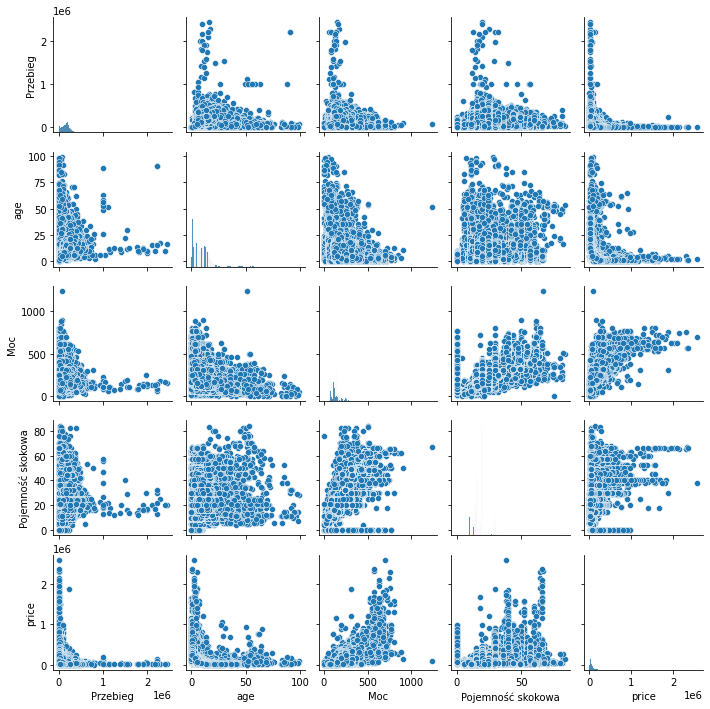

In [123]:
sns.pairplot(X_train.join(y_train)[["Przebieg", "age", "Moc", "Pojemność skokowa", "price"]], height=2)
plt.show()

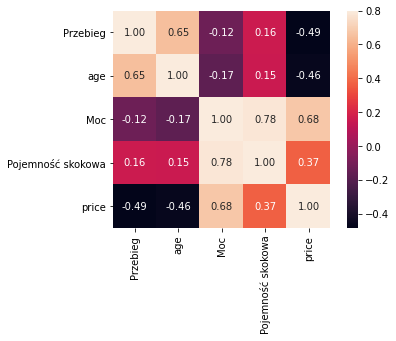

In [124]:
# Correlation matrix
corr_matr = X_train.join(y_train)\
            [["Przebieg", "age", "Moc", "Pojemność skokowa", "price"]]\
            .corr()
f, ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr_matr, annot=True, fmt='.2f', vmax=.8, square=True);

##### Price dependence on the country of origin

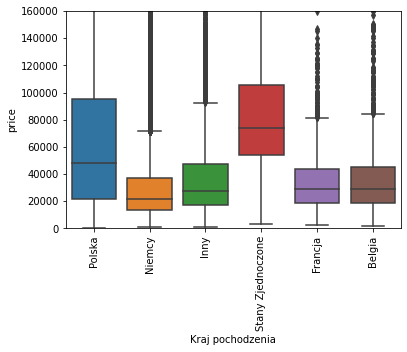

In [125]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(x=X_train["Kraj pochodzenia"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=160000)
plt.show()

##### Price dependence on the colour

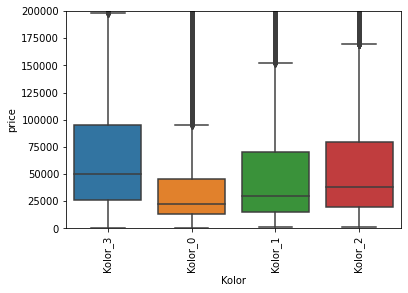

In [126]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(x=X_train["Kolor"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=200000)
plt.show()

##### Price dependence on drive type 

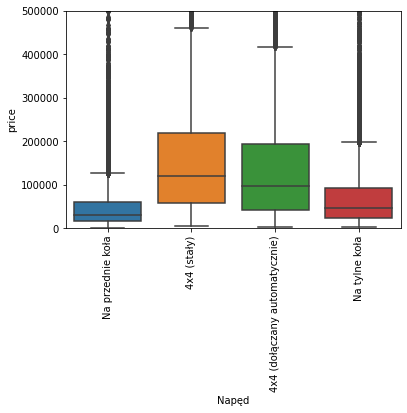

In [127]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(x=X_train["Napęd"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=500000)
plt.show()

##### Price dependence on number of doors

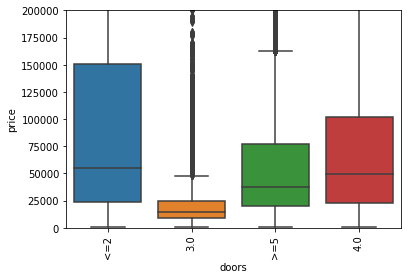

In [128]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(x=X_train["doors"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=200000)
plt.show()

##### Price dependence on number of seats

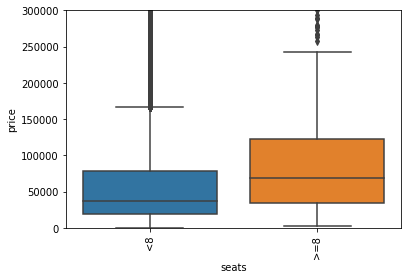

In [129]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(x=X_train["seats"], y=y_train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylim(ymin=0, ymax=300000)
plt.show()

##### Top 10 features (binary columns) most correlated with the price

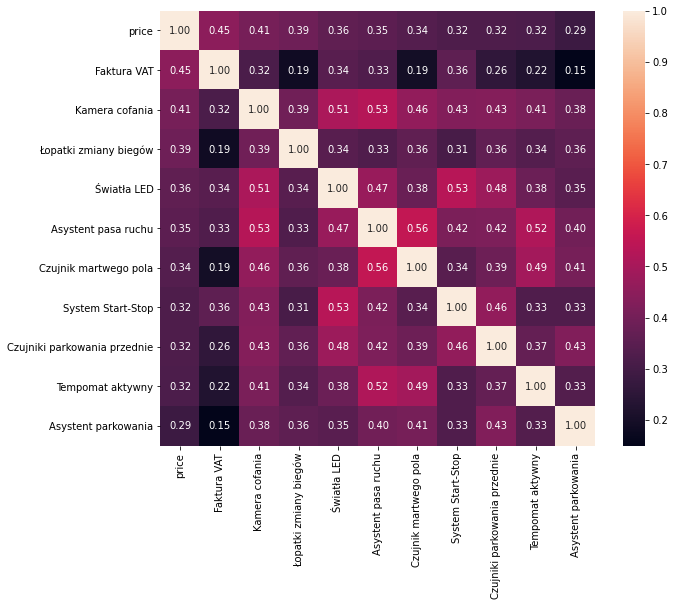

In [130]:
cols = [c for c in otomoto_preprocessor.bin_columns_ if c not in \
     ['Uszkodzony', 'Zarejestrowany jako zabytek', 'Matowy', 'Warranty if agreed with the buyer', 'Homologacja ciężarowa']]

# 10 features most correlated with the price
corr_matr = X_train[cols].join(y_train).corr()
corr_cols = corr_matr.nlargest(11, columns="price")["price"].index
cm = np.corrcoef(X_train.join(y_train)[corr_cols].values.T)
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', \
            annot_kws={'size': 10}, yticklabels=corr_cols.values, xticklabels=corr_cols.values);

##### Price dependence on price details

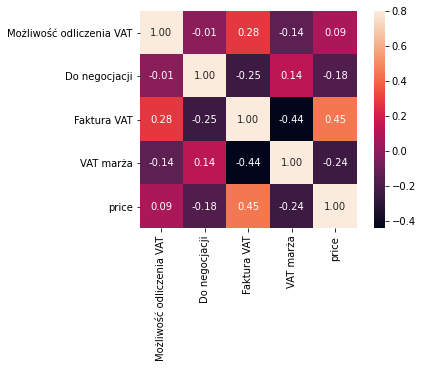

In [131]:
# Correlation matrix
corr_matr = X_train.join(y_train)[otomoto_preprocessor.price_details_ + ["VAT marża", "price"]].corr()
f, ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr_matr, annot=True, fmt='.2f', vmax=.8, square=True);

### Columns

#### The columns to be removed 
Columns without value for the prediction or converted to others:
- "href", "price_evaluation", "seller_name" - without value for price prediction
- "currency" - only PLN,
- "Oferta od" - duplicates the information from the "seller_type" field,
- "Zarejestrowany jako zabytek", "Homologacja ciężarowa", "Warranty if agreed with the buyer", "Matowy", Kod Silnika" - small number of records,
- "Emisja CO2" - small number of records and correlation with "Pojemność skokowa",
- "price_details", "Rok produkcji", "Pierwsza rejestracja", "Rodzaj paliwa", "Liczba drzwi", "Liczba miejsc", "Gwarancja dealerska (w cenie)", "Okres gwarancji producenta", "lub do (przebieg km)" - transformed to other columns,
- "Uszkodzony" - only undamaged cars are supported.

#### The columns that remain
Remaining columns will be divided into three groups:
- categorical features,
- numerical features,
- binary features.

In [132]:
remaining_cols = list(X_train.drop(columns=["href", "currency", "price_evaluation", "Oferta od", "seller_name", \
                      "Zarejestrowany jako zabytek", "Homologacja ciężarowa", "Kod Silnika", "price_details", \
                      "Emisja CO2", "Matowy", "Warranty if agreed with the buyer", "Rok produkcji", "Rodzaj paliwa", \
                      "Pierwsza rejestracja", "Liczba drzwi", "Liczba miejsc", "Gwarancja dealerska (w cenie)", \
                      "Okres gwarancji producenta", "lub do (przebieg km)", "Uszkodzony"]).columns)

In [133]:
# categorical features
cat_features = [c for c in remaining_cols if X_train[c].dtype == object]
cat_features

['seller_type',
 'Marka pojazdu',
 'Model pojazdu',
 'Skrzynia biegów',
 'Napęd',
 'Typ',
 'Kolor',
 'Kraj pochodzenia',
 'Stan',
 'Wersja',
 'Generacja',
 'fuel',
 'doors',
 'seats']

In [134]:
# numerical features
num_features = [c for c in remaining_cols if X_train[c].dtype == float]
num_features

['Przebieg', 'Pojemność skokowa', 'Moc', 'age']

In [135]:
# binary features
bin_features = [c for c in remaining_cols if X_train[c].dtype == "int8"]
bin_features

['Faktura VAT',
 'Zarejestrowany w Polsce',
 'Pierwszy właściciel',
 'Bezwypadkowy',
 'Serwisowany w ASO',
 'Metalik',
 'ABS',
 'Bluetooth',
 'Czujnik zmierzchu',
 'Elektrycznie ustawiane lusterka',
 'Gniazdo USB',
 'Klimatyzacja automatyczna',
 'MP3',
 'Poduszka powietrzna chroniąca kolana',
 'Poduszki boczne przednie',
 'Radio niefabryczne',
 'Światła do jazdy dziennej',
 'Szyberdach',
 'Alufelgi',
 'Centralny zamek',
 'Czujniki parkowania tylne',
 'ESP (stabilizacja toru jazdy)',
 'Immobilizer',
 'Komputer pokładowy',
 'Ogranicznik prędkości',
 'Poduszka powietrzna kierowcy',
 'Poduszki boczne tylne',
 'Radio fabryczne',
 'Światła LED',
 'Wielofunkcyjna kierownica',
 'ASR (kontrola trakcji)',
 'Czujnik deszczu',
 'Elektryczne szyby przednie',
 'Gniazdo AUX',
 'Isofix',
 'Kurtyny powietrzne',
 'Podgrzewane lusterka boczne',
 'Poduszka powietrzna pasażera',
 'Przyciemniane szyby',
 'Światła Xenonowe',
 'Światła przeciwmgielne',
 'Wspomaganie kierownicy',
 'Perłowy',
 'Tuning',
 'Alarm

In [136]:
# Check:
len(cat_features + num_features + bin_features) == len(remaining_cols)

True

In [137]:
# To arrange columns according to types for easier viewing:
remaining_cols = cat_features + num_features + bin_features

In [138]:
len(remaining_cols)

105

In [139]:
# Check NaNs
X_train[remaining_cols].isna().any().any()

False

In [140]:
X_train[remaining_cols].head(10000).tail(5)

,seller_type,Marka pojazdu,Model pojazdu,Skrzynia biegów,Napęd,Typ,Kolor,Kraj pochodzenia,Stan,Wersja,Generacja,fuel,doors,seats,Przebieg,Pojemność skokowa,Moc,age,Faktura VAT,Zarejestrowany w Polsce,Pierwszy właściciel,Bezwypadkowy,Serwisowany w ASO,Metalik,ABS,Bluetooth,Czujnik zmierzchu,Elektrycznie ustawiane lusterka,Gniazdo USB,Klimatyzacja automatyczna,MP3,Poduszka powietrzna chroniąca kolana,Poduszki boczne przednie,Radio niefabryczne,Światła do jazdy dziennej,Szyberdach,Alufelgi,Centralny zamek,Czujniki parkowania tylne,ESP (stabilizacja toru jazdy),Immobilizer,Komputer pokładowy,Ogranicznik prędkości,Poduszka powietrzna kierowcy,Poduszki boczne tylne,Radio fabryczne,Światła LED,Wielofunkcyjna kierownica,ASR (kontrola trakcji),Czujnik deszczu,Elektryczne szyby przednie,Gniazdo AUX,Isofix,Kurtyny powietrzne,Podgrzewane lusterka boczne,Poduszka powietrzna pasażera,Przyciemniane szyby,Światła Xenonowe,Światła przeciwmgielne,Wspomaganie kierownicy,Perłowy,Tuning,Alarm,CD,Tapicerka welurowa,Gniazdo SD,Tempomat,Dach panoramiczny,Podgrzewana przednia szyba,Klimatyzacja manualna,System Start-Stop,Akryl (niemetalizowany),VAT marża,Asystent parkowania,Klimatyzacja dwustrefowa,Regulowane zawieszenie,Nawigacja GPS,Tapicerka skórzana,Elektrochromatyczne lusterko wsteczne,Czujniki parkowania przednie,Kamera cofania,Odtwarzacz DVD,Podgrzewane przednie siedzenia,Elektrochromatyczne lusterka boczne,Tuner TV,Łopatki zmiany biegów,Elektryczne szyby tylne,Elektrycznie ustawiane fotele,Klimatyzacja czterostrefowa,Asystent pasa ruchu,Czujnik martwego pola,Zmieniarka CD,Relingi dachowe,Hak,Tempomat aktywny,Podgrzewane tylne siedzenia,Kierownica po prawej (Anglik),Ogrzewanie postojowe,Filtr cząstek stałych,HUD (wyświetlacz przezierny),first_reg_flg,gas,warranty,Możliwość odliczenia VAT,Do negocjacji
11029,Osoba prywatna,audi,"audi, a3",Manualna,Na przednie koła,Kompakt,Kolor_0,Niemcy,Używane,"audi, a3, 8p (2003-2012), inny","audi, a3, 8p (2003-2012)",Benzyna,3.0,<8,236000.0000,16.0000,102.0000,17.0000,0,1,0,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
11030,Osoba prywatna,audi,"audi, a4",Manualna,Na przednie koła,Sedan,Kolor_3,Niemcy,Używane,"audi, a4, b8 (2007-2015), 2.0 tdi","audi, a4, b8 (2007-2015)",Diesel,>=5,<8,171900.0000,20.0000,143.0000,9.0000,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
11032,Osoba prywatna,audi,"audi, a8",Automatyczna,4x4 (dołączany automatycznie),Sedan,Kolor_2,Polska,Używane,"audi, a8, d4 (2010-), inny","audi, a8, d4 (2010-)",Diesel,4.0,<8,242000.0000,41.0000,385.0000,7.0000,1,1,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0
11033,Autoryzowany Dealer,audi,"audi, inny",Automatyczna,Na przednie koła,Auta miejskie,Kolor_3,Polska,Używane,"audi, inny, inny, inny","audi, inny, inny",Benzyna,>=5,<8,2000.0000,15.0000,150.0000,1.0000,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11035,Osoba prywatna,audi,"audi, a3",Manualna,Na przednie koła,Auta miejskie,Kolor_2,Polska,Używane,"audi, a3, 8p (2003-2012), inny","audi, a3, 8p (2003-2012)",Benzyna,>=5,<8,156000.0000,16.0000,102.0000,12.0000,0,0,0,0,0,0,1,0,1,1,0,1,1,1,1,0,0,0,1,1,1,0,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


#### ColumnTransformer
Change categorical columns to one-hots and scale numeric columns:

In [141]:
class MyOneHotEncoder(OneHotEncoder):
    """
    OneHotEncoder with the option of giving y as a parameter (y will be ignored) 
    """
    
    def __init__(self, dtype="int8", sparse=False, drop=None, handle_unknown="ignore"):     
        super().__init__(sparse=sparse, dtype=dtype, drop=None, handle_unknown=handle_unknown)
            
            
    def fit(self, X, y=None):
        return super().fit(X)

    
    def transform(self, X, y=None):        
        return super().transform(X)

In [142]:
class MyStandardScaler(StandardScaler):
    """
    StandardScaler which provides get_feature_names
    """          
            
    def fit(self, X, y=None):
        self.columns = X.columns
        return super().fit(X)

    
    def transform(self, X, y=None):        
        return super().transform(X)
    
    
    def get_feature_names(self):
        return self.columns

In [143]:
class MyColumnTransformer(ColumnTransformer):
    """
    ColumnTransformer with the option of giving y as a parameter (y will be ignored).
    It changes data to float32.
    """               
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):   
        X = super().transform(X)
        if X.dtype == "float64":
            X = X.astype("float32")
        return X

In [144]:
column_transformer = MyColumnTransformer(transformers=[
    ("cat_pipe", MyOneHotEncoder(), cat_features),
    ("num_pipe", MyStandardScaler(), num_features),
    ("bin_pipe", "passthrough", bin_features)],
    remainder="drop",
    n_jobs=2
)

In [145]:
column_transformer.fit(X_train)

MyColumnTransformer(n_jobs=2,
                    transformers=[('cat_pipe', MyOneHotEncoder(),
                                   ['seller_type', 'Marka pojazdu',
                                    'Model pojazdu', 'Skrzynia biegów', 'Napęd',
                                    'Typ', 'Kolor', 'Kraj pochodzenia', 'Stan',
                                    'Wersja', 'Generacja', 'fuel', 'doors',
                                    'seats']),
                                  ('num_pipe', MyStandardScaler(),
                                   ['Przebieg', 'Pojemność skokowa', 'Moc',
                                    'age']),
                                  ('bin_pipe', 'passthrough',
                                   ['Faktura VAT', 'Zarej...
                                    'Poduszka powietrzna chroniąca kolana',
                                    'Poduszki boczne przednie',
                                    'Radio niefabryczne',
                                    'Światła do jazdy dziennej', 'Szyberdach',
                                    'Alufelgi', 'Centralny zamek',
                                    'Czujniki parkowania tylne',
                                    'ESP (stabilizacja toru jazdy)',
                                    'Immobilizer', 'Komputer pokładowy',
                                    'Ogranicznik prędkości',
                                    'Poduszka powietrzna kierowcy',
                                    'Poduszki boczne tylne', 'Radio fabryczne',
                                    'Światła LED', 'Wielofunkcyjna kierownica', ...])])

In [146]:
X_train = column_transformer.transform(X_train)

In [147]:
X_train.dtype

dtype('float32')

In [148]:
# Data set after transformation:
pd.DataFrame(X_train, columns=column_transformer.get_feature_names()).head()

,cat_pipe__x0_Autoryzowany Dealer,cat_pipe__x0_Dealer,cat_pipe__x0_Osoba prywatna,cat_pipe__x1_alfa romeo,cat_pipe__x1_audi,cat_pipe__x1_bmw,cat_pipe__x1_chevrolet,cat_pipe__x1_chrysler,cat_pipe__x1_citroën,cat_pipe__x1_dacia,cat_pipe__x1_dodge,cat_pipe__x1_fiat,cat_pipe__x1_ford,cat_pipe__x1_honda,cat_pipe__x1_hyundai,cat_pipe__x1_inny,cat_pipe__x1_jaguar,cat_pipe__x1_jeep,cat_pipe__x1_kia,cat_pipe__x1_land rover,cat_pipe__x1_lexus,cat_pipe__x1_mazda,cat_pipe__x1_mercedes-benz,cat_pipe__x1_mini,cat_pipe__x1_mitsubishi,cat_pipe__x1_nissan,cat_pipe__x1_opel,cat_pipe__x1_peugeot,cat_pipe__x1_porsche,cat_pipe__x1_renault,cat_pipe__x1_saab,cat_pipe__x1_seat,cat_pipe__x1_smart,cat_pipe__x1_subaru,cat_pipe__x1_suzuki,cat_pipe__x1_toyota,cat_pipe__x1_volkswagen,cat_pipe__x1_volvo,cat_pipe__x1_škoda,"cat_pipe__x2_alfa romeo, 159","cat_pipe__x2_alfa romeo, giulietta","cat_pipe__x2_alfa romeo, inny","cat_pipe__x2_alfa romeo, stelvio","cat_pipe__x2_audi, a3","cat_pipe__x2_audi, a4","cat_pipe__x2_audi, a5","cat_pipe__x2_audi, a6","cat_pipe__x2_audi, a7","cat_pipe__x2_audi, a8","cat_pipe__x2_audi, inny","cat_pipe__x2_audi, q3","cat_pipe__x2_audi, q5","cat_pipe__x2_audi, q7","cat_pipe__x2_bmw, 3gt","cat_pipe__x2_bmw, inny","cat_pipe__x2_bmw, seria 1","cat_pipe__x2_bmw, seria 2","cat_pipe__x2_bmw, seria 3","cat_pipe__x2_bmw, seria 4","cat_pipe__x2_bmw, seria 5","cat_pipe__x2_bmw, seria 7","cat_pipe__x2_bmw, x1","cat_pipe__x2_bmw, x3","cat_pipe__x2_bmw, x5","cat_pipe__x2_bmw, x6","cat_pipe__x2_chevrolet, aveo","cat_pipe__x2_chevrolet, cruze","cat_pipe__x2_chevrolet, inny","cat_pipe__x2_chrysler, inny","cat_pipe__x2_citroën, berlingo","cat_pipe__x2_citroën, c1","cat_pipe__x2_citroën, c3","cat_pipe__x2_citroën, c3 aircross","cat_pipe__x2_citroën, c3 picasso","cat_pipe__x2_citroën, c4","cat_pipe__x2_citroën, c4 cactus","cat_pipe__x2_citroën, c4 grand picasso","cat_pipe__x2_citroën, c4 picasso","cat_pipe__x2_citroën, c5","cat_pipe__x2_citroën, c5 aircross","cat_pipe__x2_citroën, inny","cat_pipe__x2_dacia, duster","cat_pipe__x2_dacia, inny","cat_pipe__x2_dacia, sandero","cat_pipe__x2_dacia, sandero stepway","cat_pipe__x2_dodge, inny","cat_pipe__x2_fiat, 500","cat_pipe__x2_fiat, bravo","cat_pipe__x2_fiat, doblo","cat_pipe__x2_fiat, grande punto","cat_pipe__x2_fiat, inny","cat_pipe__x2_fiat, panda","cat_pipe__x2_fiat, tipo","cat_pipe__x2_ford, c-max","cat_pipe__x2_ford, fiesta","cat_pipe__x2_ford, focus","cat_pipe__x2_ford, galaxy","cat_pipe__x2_ford, grand c-max","cat_pipe__x2_ford, inny","cat_pipe__x2_ford, kuga","cat_pipe__x2_ford, mondeo","cat_pipe__x2_ford, mustang","cat_pipe__x2_ford, puma","cat_pipe__x2_ford, s-max","cat_pipe__x2_honda, accord","cat_pipe__x2_honda, civic","cat_pipe__x2_honda, cr-v","cat_pipe__x2_honda, hr-v","cat_pipe__x2_honda, inny","cat_pipe__x2_honda, jazz","cat_pipe__x2_hyundai, i10","cat_pipe__x2_hyundai, i20","cat_pipe__x2_hyundai, i30","cat_pipe__x2_hyundai, i40","cat_pipe__x2_hyundai, inny","cat_pipe__x2_hyundai, ix35","cat_pipe__x2_hyundai, tucson",cat_pipe__x2_inny,"cat_pipe__x2_inny, inny","cat_pipe__x2_jaguar, inny","cat_pipe__x2_jeep, compass","cat_pipe__x2_jeep, grand cherokee","cat_pipe__x2_jeep, inny","cat_pipe__x2_jeep, renegade","cat_pipe__x2_kia, ceed","cat_pipe__x2_kia, inny","cat_pipe__x2_kia, optima","cat_pipe__x2_kia, picanto","cat_pipe__x2_kia, rio","cat_pipe__x2_kia, sorento","cat_pipe__x2_kia, sportage","cat_pipe__x2_kia, stonic","cat_pipe__x2_kia, venga","cat_pipe__x2_land rover, inny","cat_pipe__x2_lexus, inny","cat_pipe__x2_lexus, is","cat_pipe__x2_lexus, nx","cat_pipe__x2_mazda, 2","cat_pipe__x2_mazda, 3","cat_pipe__x2_mazda, 5","cat_pipe__x2_mazda, 6","cat_pipe__x2_mazda, cx-3","cat_pipe__x2_mazda, cx-5","cat_pipe__x2_mazda, inny","cat_pipe__x2_mercedes-benz, cla","cat_pipe__x2_mercedes-benz, cls","cat_pipe__x2_mercedes-benz, gla","cat_pipe__x2_mercedes-benz, glc","cat_pipe__x2_mercedes-benz, gle","cat_pipe__x2_mercedes-benz, inny","cat_pipe__x2_mercedes-benz, klasa a","cat_pipe__x2_mercedes-be

In [149]:
X_train.shape

(175005, 1119)

#### [Save checkpoint]

In [150]:
# Dump X_train and y_train to pickle
with open("/".join([path, "X_train_3.obj"]), "wb") as fp:
    pickle.dump(X_train, fp)
    
with open("/".join([path, "y_train_3.obj"]), "wb") as fp:
    pickle.dump(y_train, fp)

In [151]:
# Read X_train and y_train from pickle 
with open("/".join([path, "X_train_3.obj"]), 'rb') as fp:
    X_train = pickle.load(fp)
    
with open("/".join([path, "y_train_3.obj"]), 'rb') as fp:
    y_train = pickle.load(fp)

### Dimensionality reduction
Principal Component Analysis for dimensionality reduction. It is carried out by the orthogonal projection of the data onto a lower dimensional linear space, known as the principal subspace, such that the variance of the projected data is maximized. After projection original features no longer exist and new features are constructed from the available data.

In [152]:
# Reduce the dimension maintaining 90% of the variance
pca = PCA(n_components=0.90)
pca.fit(X_train)

PCA(n_components=0.9)

In [153]:
X_train = pca.transform(X_train)

In [154]:
print("Number of new variables: {}\r\nShape of data after the projection onto new space: {}".\
      format(pca.n_components_, str(X_train.shape)))

Number of new variables: 130
Shape of data after the projection onto new space: (175005, 130)


In [155]:
# Shares of the obtained new variables in the variance:
print(pca.explained_variance_ratio_)

[0.16453294 0.08712706 0.07566307 0.02544915 0.02073045 0.01822673
 0.01676774 0.01469485 0.01314695 0.01236784 0.0120592  0.01128363
 0.01081795 0.00981988 0.00959053 0.00904155 0.0088198  0.00861081
 0.00842508 0.00813667 0.00782217 0.0074037  0.00720357 0.00715564
 0.00704751 0.00669042 0.0065068  0.00637467 0.00628732 0.00619075
 0.00603405 0.0059972  0.00583809 0.00568556 0.00560261 0.00553822
 0.005309   0.00525307 0.00514426 0.00509423 0.00503444 0.00495798
 0.00484819 0.00475749 0.00464332 0.00463332 0.00454199 0.00447842
 0.00445415 0.00436421 0.0041788  0.00411642 0.00395235 0.00392967
 0.00388639 0.00380542 0.00375867 0.00372297 0.00368203 0.00358036
 0.00351216 0.00348628 0.00342693 0.00339435 0.00334028 0.00330702
 0.00324463 0.00321061 0.00317206 0.00309688 0.0030666  0.00297276
 0.00296679 0.00291454 0.00285337 0.00281045 0.00277223 0.00271237
 0.0026828  0.00266755 0.00264588 0.00256584 0.00250414 0.00242229
 0.00241042 0.00235249 0.00230987 0.00228414 0.00225565 0.0022

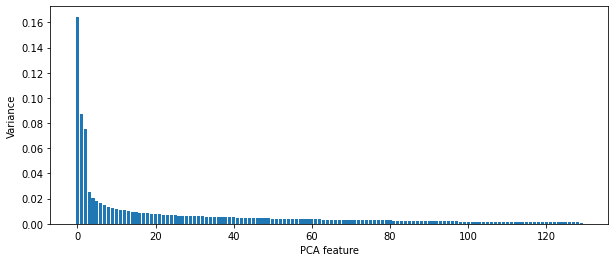

In [156]:
# Shares in variance for successive features:
plt.figure(figsize=(10,4))
features = range(pca.n_components_) 
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(np.arange(0, pca.n_components_, step=20)) 
plt.show()

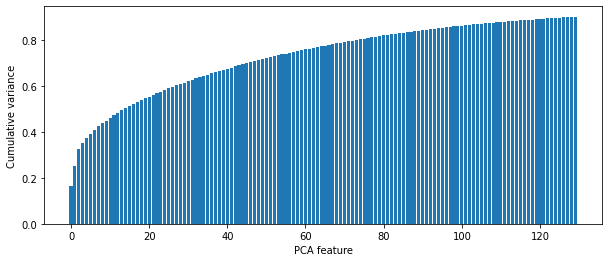

In [157]:
# Cumulative diagram
plt.figure(figsize=(10,4))
plt.bar(range(pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PCA feature')
plt.ylabel('Cumulative variance')
plt.xticks(np.arange(0, pca.n_components_, step=20)) 
plt.show()

In [158]:
# Shares of individual columns in features after dimension reduction
pca_columns = ["_".join(["pca", str(i)]) for i in range (pca.n_components_)]
loadings = pd.DataFrame(pca.components_.T, columns=pca_columns, index=column_transformer.get_feature_names())
loadings

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,pca_51,pca_52,pca_53,pca_54,pca_55,pca_56,pca_57,pca_58,pca_59,pca_60,pca_61,pca_62,pca_63,pca_64,pca_65,pca_66,pca_67,pca_68,pca_69,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79,pca_80,pca_81,pca_82,pca_83,pca_84,pca_85,pca_86,pca_87,pca_88,pca_89,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99,pca_100,pca_101,pca_102,pca_103,pca_104,pca_105,pca_106,pca_107,pca_108,pca_109,pca_110,pca_111,pca_112,pca_113,pca_114,pca_115,pca_116,pca_117,pca_118,pca_119,pca_120,pca_121,pca_122,pca_123,pca_124,pca_125,pca_126,pca_127,pca_128,pca_129
cat_pipe__x0_Autoryzowany Dealer,-0.0451,-0.1187,0.0781,0.0165,0.0581,0.0316,-0.1182,0.0666,0.0136,-0.0630,-0.0479,0.1840,-0.0511,-0.0242,-0.0408,0.0652,0.0480,0.0597,-0.0205,0.0679,-0.0165,0.0874,0.0044,-0.0959,-0.0409,0.1162,-0.1038,0.0075,0.0731,0.0367,0.1234,-0.0006,0.1632,-0.0825,-0.0185,0.0122,0.0340,-0.0224,0.0224,0.2316,0.0939,-0.1645,0.0838,-0.2079,-0.2051,0.2209,0.0681,-0.1719,-0.0889,-0.1027,-0.0875,0.1555,0.0142,-0.0497,-0.0407,-0.0488,-0.0851,0.0901,0.0356,-0.0429,-0.0142,-0.0103,0.0841,-0.0031,-0.0512,0.0554,0.0564,0.0061,0.0183,0.0625,-0.0305,0.0091,0.0186,-0.0132,-0.0669,-0.0097,0.0472,-0.0248,-0.0194,0.0582,0.0256,-0.0117,-0.1319,0.0694,-0.0105,0.0151,-0.1189,-0.0108,-0.0247,0.0417,-0.1017,-0.0685,0.0151,0.0931,0.0905,-0.0174,0.0123,-0.0001,0.0150,-0.0043,-0.0309,-0.0276,0.0010,-0.0220,-0.0028,-0.0111,0.0152,-0.0063,0.0141,-0.0197,0.0131,0.0165,0.0559,-0.0238,-0.0036,-0.0259,0.0022,-0.0186,0.0003,-0.0099,0.0093,0.0320,0.0267,0.0381,0.0036,0.0085,-0.0140,-0.0014,-0.0113,-0.0048
cat_pipe__x0_Dealer,0.0073,-0.0089,-0.0582,-0.1903,-0.3803,0.2514,0.0758,0.0795,-0.2497,0.1338,0.1921,-0.1714,0.1881,0.1065,0.0366,-0.0063,-0.1206,-0.0600,0.0717,-0.0547,0.0455,-0.0750,-0.0257,0.0767,0.0420,-0.0658,0.0289,-0.0276,-0.1339,-0.0050,-0.1977,0.0016,-0.1068,0.0200,0.0382,-0.0464,0.0254,0.0591,-0.0233,-0.0934,-0.0846,0.0797,-0.0377,0.1084,0.0816,-0.1146,-0.0040,0.0566,0.0246,0.0654,0.0313,-0.0690,0.0002,0.0075,0.0335,0.0204,0.0155,0.0041,-0.0019,0.0057,0.0158,-0.0090,0.0070,-0.0069,0.0267,-0.0201,-0.0141,-0.0156,0.0043,-0.0302,-0.0142,-0.0169,-0.0149,0.0236,0.0128,0.0050,-0.0137,-0.0235,0.0124,0.0111,-0.0252,-0.0153,-0.0719,0.0064,0.0024,-0.0057,-0.0257,0.0124,0.0063,0.0067,0.0030,0.0140,0.0113,0.0154,-0.0093,0.0037,0.0146,-0.0078,-0.0143,-0.0093,0.0064,-0.0077,0.0081,-0.0037,-0.0034,0.0012,-0.0038,0.0021,-0.0089,0.0039,-0.0132,-0.0062,-0.0269,0.0161,0.0049,0.0052,-0.0130,0.0059,0.0087,0.0001,-0.0030,-0.0061,-0.0040,-0.0088,-0.0031,-0.0020,-0.0004,0.0014,0.0039,0.0031
cat_pipe__x0_Osoba prywatna,0.0378,0.1276,-0.0199,0.1738,0.3221,-0.2830,0.0424,-0.1461,0.2361,-0.0707,-0.1442,-0.0126,-0.1369,-0.0824,0.0042,-0.0589,0.0726,0.0003,-0.0513,-0.0131,-0.0291,-0.0124,0.0213,0.0191,-0.0011,-0.0504,0.0750,0.0201,0.0608,-0.0317,0.0743,-0.0011,-0.0563,0.0625,-0.0197,0.0342,-0.0594,-0.0367,0.0009,-0.1382,-0.0093,0.0848,-0.0461,0.0995,0.1235,-0.1063,-0.0641,0.1153,0.0642,0.0372,0.0562,-0.0866,-0.0144,0.0421,0.0072,0.0283,0.0696,-0.0942,-0.0337,0.0372,-0.0016,0.0193,-0.0911,0.0100,0.0245,-0.0353,-0.0423,0.0095,-0.0226,-0.0324,0.0447,0.0078,-0.0037,-0.0104,0.0542,0.0047,-0.0336,0.0483,0.0070,-0.0693,-0.0004,0.0270,0.2038,-0.0758,0.0082,-0.0093,0.1445,-0.0016,0.0184,-0.0483,0.0987,0.0545,-0.0264,-0.1085,-0.0812,0.0138,-0.0269,0.0079,-0.0007,0.0136,0.0245,0.0353,-0.0091,0.0257,0.0062,0.0099,-0.0114,0.0041,-0.0051,0.0158,0.0001,-0.0103,-0.0289,0.0078,-0.0014,0.0207,0.0108,0.0127,-0.0090,0.0097,-0.0063,-0.0259,-0.0228,-0.0293,-0.0005,-0.0065,0.0143,0.0000,0.0073,0.0017
cat_pipe__x1_alfa romeo,-0.0000,0.0002,0.0012,-0.0015,0.0028,0.000

In [159]:
X_train.dtype

dtype('float32')

#### [Save checkpoint]

In [160]:
# Dump X_train to pickle
with open("/".join([path, "X_train_pca.obj"]), "wb") as fp:
    pickle.dump(X_train, fp)

In [161]:
# Read X_train from pickle 
with open("/".join([path, "X_train_pca.obj"]), 'rb') as fp:
    X_train = pickle.load(fp)

## Prepared transformer

In [162]:
estimators = []
estimators.append(("capacityimputer", AggregateImputer(column="Pojemność skokowa", \
                                      grouping_columns=["Marka pojazdu", "Model pojazdu", "fuel"], \
                                      aggregate="median")))
estimators.append(("enginepowerred1", EnginePowerDiscrReducer(subset="subset1", n_lower=0.5, n_upper=2.5)))  
estimators.append(("enginepowerred2", EnginePowerDiscrReducer(subset="subset1", n_lower=0.15, n_upper=3)))  
estimators.append(("enginepoweraggr", AggregateImputer(column="Moc", aggregate="median")))
estimators.append(("mileageimputer",  AggregateImputer(column="Przebieg", grouping_columns="age", \
                                      aggregate="median", alternative="ffill")))
estimators.append(("hierarchicalcat", HierarchicalColumnsCategorizer(\
                                      columns=["Marka pojazdu", "Model pojazdu", "Generacja", "Wersja"], 
                                      min_size=200, unknown_value="inny")))
estimators.append(("countrymerger",   SmallGroupsMerger(column="Kraj pochodzenia", \
                                      min_size=2000, unknown_value="Inny", fillna_value="Polska")))
estimators.append(("coloursmerger",   QuantilesMerger(column="Kolor", bins=4, default_value="Inny kolor")))
estimators.append(("columntransform", MyColumnTransformer(transformers=[
                                      ("cat_pipe", MyOneHotEncoder(), cat_features),
                                      ("num_pipe", MyStandardScaler(), num_features),
                                      ("bin_pipe", "passthrough", bin_features)],
                                      remainder="drop", 
                                      n_jobs=2)))
estimators.append(("pca",             PCA(n_components=0.90)))

transformer = Pipeline(estimators)

In [163]:
# Dump X_train to pickle
with open("/".join([path, "OtoMotoTransformer.obj"]), "wb") as fp:
    pickle.dump(transformer, fp)


## Bulding and evaluation of model 
- file: OtoMoto 3 - Price Prediction.ipynb




## Description of requirements for data

#### Data format

The data, which are forwarded to the transformer, should be structured as follows (additional fields are possible but will be ignored):

**Categorical data:**<br>

 'seller_type',
 'Marka pojazdu',
 'Model pojazdu', 
 'Generacja',
 'Wersja',
 'Napęd',
 'Typ',
 'Kolor',
 'Kraj pochodzenia',
 'Stan' (Używane/Nowe),
 'Skrzynia biegów' (Manualna/Automatyczna)


**Numerical data:** <br>

'Przebieg', 'Pojemność skokowa', 'Moc', 'Rok produkcji', "Liczba miejsc", "Liczba drzwi"


**Binary data:** <br>


'Faktura VAT',
 'Zarejestrowany w Polsce',
 'Pierwszy właściciel',
 'Bezwypadkowy',
 'Serwisowany w ASO',
 'Metalik',
 'ABS',
 'Bluetooth',
 'Czujnik zmierzchu',
 'Elektrycznie ustawiane lusterka',
 'Gniazdo USB',
 'Klimatyzacja automatyczna',
 'MP3',
 'Poduszka powietrzna chroniąca kolana',
 'Poduszki boczne przednie',
 'Radio niefabryczne',
 'Światła do jazdy dziennej',
 'Szyberdach',
 'Alufelgi',
 'Centralny zamek',
 'Czujniki parkowania tylne',
 'ESP (stabilizacja toru jazdy)',
 'Immobilizer',
 'Komputer pokładowy',
 'Ogranicznik prędkości',
 'Poduszka powietrzna kierowcy',
 'Poduszki boczne tylne',
 'Radio fabryczne',
 'Światła LED',
 'Wielofunkcyjna kierownica',
 'ASR (kontrola trakcji)',
 'Czujnik deszczu',
 'Elektryczne szyby przednie',
 'Gniazdo AUX',
 'Isofix',
 'Kurtyny powietrzne',
 'Podgrzewane lusterka boczne',
 'Poduszka powietrzna pasażera',
 'Przyciemniane szyby',
 'Światła Xenonowe',
 'Światła przeciwmgielne',
 'Wspomaganie kierownicy',
 'Perłowy',
 'Tuning',
 'Alarm',
 'CD',
 'Tapicerka welurowa',
 'Gniazdo SD',
 'Tempomat',
 'Dach panoramiczny',
 'Podgrzewana przednia szyba',
 'Klimatyzacja manualna',
 'System Start-Stop',
 'Akryl (niemetalizowany)',
 'VAT marża',
 'Asystent parkowania',
 'Klimatyzacja dwustrefowa',
 'Regulowane zawieszenie',
 'Nawigacja GPS',
 'Tapicerka skórzana',
 'Elektrochromatyczne lusterko wsteczne',
 'Czujniki parkowania przednie',
 'Kamera cofania',
 'Odtwarzacz DVD',
 'Podgrzewane przednie siedzenia',
 'Elektrochromatyczne lusterka boczne',
 'Tuner TV',
 'Łopatki zmiany biegów',
 'Elektryczne szyby tylne',
 'Elektrycznie ustawiane fotele',
 'Klimatyzacja czterostrefowa',
 'Asystent pasa ruchu',
 'Czujnik martwego pola',
 'Zmieniarka CD',
 'Relingi dachowe',
 'Hak',
 'Tempomat aktywny',
 'Podgrzewane tylne siedzenia',
 'Kierownica po prawej (Anglik)',
 'Ogrzewanie postojowe',
 'Filtr cząstek stałych',
 'HUD (wyświetlacz przezierny)',
 "price_details", 
 "Matowy", 
 "Rodzaj paliwa", 
 "Pierwsza rejestracja", 
 "Gwarancja dealerska (w cenie)", 
 "Okres gwarancji producenta", 
 "lub do (przebieg km)"
 

#### Additional remarks:
Prices should be given only in PLN.<br>
It is also required to remove damaged cars from the data. 


Numeric fields should be passed as float variables (after removing units). <br>
The remaining fields (including binary variables) should be passed to the transformer as text variables.



#### Description of selected columns:
- **href:** link to the offer on the website (auxiliary for data analysis),
- **price_evaluation:** indicates whether the car's price is in the mid-range, above or below; not used in price prediction (not used for price prediction, but can be the basis for offer classification)
- **currency:** only PLN supported (offers in other currencies should be removed from the data)
- **price_details:** additional information regarding the price, e.g. whether the price is negotiable,
- **seller_type:** offer from a private person or from a dealer,
- **seller_name:** field not used in price prediction,
- **Oferta od:** similar to "seller_type",
- **Marka pojazdu:** car brands,
- **Model pojazdu:** car models,
- **Generacja:** car generation, 
- **Wersja:** car version, 
- **Rok produkcji:** year of production,
- **Przebieg:** mileage,
- **Pojemność skokowa:** engine capacity,
- **Rodzaj paliwa:** type of fuel,
- **Moc:** engine power,	
- **Emisja CO2:** CO2 emission, 
- **Skrzynia biegów:** gearbox (automatic / manual),
- **Napęd:** drive (front wheel / rear wheel / 4x4),
- **Typ:** types of cars,
- **Liczba drzwi:** number of doors,
- **Liczba miejsc:** number of seats,
- **Kolor:** colours,
- **Faktura VAT:** the invoice includes VAT,
- **VAT marża:** the possibility of tax reduction by settling VAT on the margin, 
- **Kraj pochodzenia:** country of origin,
- **Pierwsza rejestracja:** date of the first registration,
- **Zarejestrowany w Polsce:** car registered in Poland,
- **Pierwszy właściciel:** purchase from the first owner,
- **Bezwypadkowy:** accident-free,
- **Serwisowany w ASO:** serviced at authorized service station,
- **Stan:** condition (new / used),
- **Uszkodzony:** damaged car, 
- **ADDITIONAL FEATURES** (yes/no): On board computer, ABS, ESP (stabilization program), ASR (traction control), Power steering, Multifunction steering wheel, Manual air conditioning, Automatic air conditioning, Four-zone air conditioning, Dual-zone air conditioning, Particulate filter, Driver airbag, Passenger airbag, Sidebags Rear, Knee protection airbag, Front side airbags, Curtains, Dusk sensor, Daytime running lights, Xenon lights, Fog lights, LED lights, Blind spot sensor, Rear parking sensors, Front parking sensors, Reversing camera, Central locking, Immobilizer , Alarm, Cruise control active, Speed limiter, Rain sensor, Heated windshield, Electric front windows, Electric mirrors, Heated door mirrors, Tinted windows, Metallic, Pearl, Matt, Acrylic (non-metallic), Tuning, Cruise control, Panoramic roof, System Start-Stop, Parking assistant, Adjustable hinge Sewing, Velor upholstery, Leather upholstery, Electrochromic rearview mirror, Electrochromic side mirrors, Electric rear windows, Electrically adjustable seats, Heated front seats, Heated rear seats, Auxiliary heating, Gear shift paddles, Lane assistant, Sunroof, Roof rails, Alloy rims, Hook, Right hand drive (English), Manufacturer's warranty period, or up to (mileage), Dealer warranty (included), Isofix, HUD (Head-up display), Truck approval, Registered historic, Code Engine, GPS Navigation, Aftermarket Radio, Factory Radio, SD Slot, TV Tuner, Bluetooth, USB Slot, MP3, CD, CD Changer, DVD Player, AUX Socket


Data set y_train/y_test should contain car prices in PLN.

